In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import tarfile
import io

from scipy.spatial.distance import pdist, squareform

# Metagenome analysis

In [8]:
def plot_duplicates(abs_genome_freq, rel_genome_freq):
    """
    Plot the number of duplicates per genome.
    """
    fig, ax = plt.subplots(figsize=(20, 60))

    abs_genome_freq.plot.barh(ax=ax, color='blue', alpha=0.5, label='Absolute duplicates')
    rel_genome_freq.plot.barh(ax=ax, color='red', alpha=0.5, label='Relative duplicates')

    plt.title('Number of duplicates per genome')
    plt.xlabel('Genome frequency')
    plt.ylabel('Genome')
    plt.legend()
    plt.show()

In [3]:
def genome_boxplot(df, title, color):
    """
    Create a boxplot for each genome.
    """
    plt.figure(figsize=(20, 10))

    # melt and logscale genomes
    df_melted = np.log1p(df).melt(var_name='Amino', value_name='Count')

    # create a boxplot for each genome
    sns.boxplot(x='Amino', y='Count', data=df_melted, color=color)

    plt.title(title)
    plt.xlabel('Amino')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def plot_genome_density(df, gene, ax):
    """
    Plot the density of a specific genome.
    """
    sns.histplot(data=np.log1p(df), x=gene, bins=30, kde=True, ax=ax)
    ax.set_title(f'{gene} Density (log-scaled)')
    ax.set_xlabel('Counts')
    ax.set_ylabel('Frequency')

In [5]:
def plot_heatmap(df, log_scale=False):
    """
    Plot a heatmap of log-scaled counts.
    """
    plt.figure(figsize=(30, 160))
    if log_scale:
        sns.heatmap(np.log1p(df), cmap='viridis')
    else:
        sns.heatmap(df, cmap='viridis')

    plt.title('Heatmap of top Counts')
    plt.xlabel('Amino')
    plt.ylabel('Replicate')
    plt.show()

In [6]:
def plot_clustermap(df, method='ward', col_cluster=True, row_cluster=False):
    """
    Plot a clustermap of log-scaled counts using Jaccard distance.
    """
    # Calculate the Jaccard distance between each pair of columns
    jaccard_dist = pdist(df.T, 'jaccard')
    # Convert the distances to a square matrix
    jaccard_dist_matrix = squareform(jaccard_dist)
    
    grid = sns.clustermap(jaccard_dist_matrix, cmap='viridis', method=method, col_cluster=col_cluster, row_cluster=row_cluster)
    plt.close()

    col_order = grid.dendrogram_col.reordered_ind
    df_clustered = df.iloc[:, col_order]

    plot_heatmap(df_clustered)

In [22]:
#import data
abs_df = pd.read_csv('../data/d__Bacteria_absolute_freqs_ed.tsv', sep='\t', index_col=0)
rel_df = pd.read_csv('../data/d__Bacteria_rel_syn_freqs_ed.tsv', sep='\t', index_col=0)

abs_df.head(5)

genome      source accession  \
3  GCA_000517565_1  KEGG_BRITE   ko00001   
4  GCA_000517565_1  KEGG_BRITE   ko00001   
5  GCA_000517565_1  KEGG_BRITE   ko00001   
6  GCA_000517565_1  KEGG_BRITE   ko00001   
7  GCA_000517565_1  KEGG_BRITE   ko00001   

                                                name    AAA    AAC    AAG  \
3  KEGG Orthology (KO)>>>09100 Metabolism>>>09101...  891.0  207.0  132.0   
4  KEGG Orthology (KO)>>>09100 Metabolism>>>09101...  776.0  177.0  144.0   
5  KEGG Orthology (KO)>>>09100 Metabolism>>>09101...  274.0   72.0   64.0   
6  KEGG Orthology (KO)>>>09100 Metabolism>>>09101...  114.0   22.0   18.0   
7  KEGG Orthology (KO)>>>09100 Metabolism>>>09101...  336.0   69.0   53.0   

     AAT    ACA   ACC  ...   TCG    TCT   TGA   TGC    TGG   TGT    TTA   TTC  \
3  414.0  364.0  51.0  ...  34.0  171.0  10.0  73.0  100.0  70.0  344.0  44.0   
4  311.0  329.0  47.0  ...  30.0  161.0   7.0  69.0   95.0  68.0  307.0  44.0   
5  137.0  126.0  18.0  ...  12.0   80.0   3.0  20.0   22.0  33.0  114.0  21.0   
6   73.0   33.0   3.0  ...   6.0   18.0   3.0   6.0    8.0   7.0   57.0   4.0   
7  184.0  124.0   9.0  ...  12.0   64.0   5.0  20.0   27.0  29.0  129.0  11.0   

     TTG    TTT  
3  167.0  494.0  
4  146.0  411.0  
5   80.0  168.0  
6   24.0   71.0  
7   72.0  194.0  

[5 rows x 68 columns]

In [7]:
abs_df.name.value_counts()

KEGG Orthology (KO)>>>09100 Metabolism>>>09101 Carbohydrate metabolism>>>00010 Glycolysis / Gluconeogenesis [PATH:ko00010]          201
Transfer RNA biogenesis>>>Prokaryotic type>>>tRNA modification factors>>>Other tRNA modification factors                            201
KEGG Orthology (KO)>>>09100 Metabolism>>>09104 Nucleotide metabolism>>>00240 Pyrimidine metabolism [PATH:ko00240]                   201
KEGG Orthology (KO)>>>09120 Genetic Information Processing>>>09124 Replication and repair>>>03030 DNA replication [PATH:ko03030]    201
Transfer RNA biogenesis>>>Prokaryotic type>>>Aminoacyl-tRNA synthetases (AARSs)>>>Other AARSs                                       201
                                                                                                                                   ... 
Enzymes>>>1. Oxidoreductases>>>1.97  Other oxidoreductases>>>1.97.-                                                                   1
Ubiquitin system>>>Ubiquitin ligases (E3)>>>Mult

NOTE: The duplicates in genomes are due to different functions associated with corresponding codons, i.e. the primary key is genome name +  function

In [12]:
# make indices start from 0
abs_df = abs_df.reset_index(drop=True)
rel_df = rel_df.reset_index(drop=True)

# check if the set of genomes is the same
print(set(abs_df["genome"]) == set(rel_df["genome"]))

True


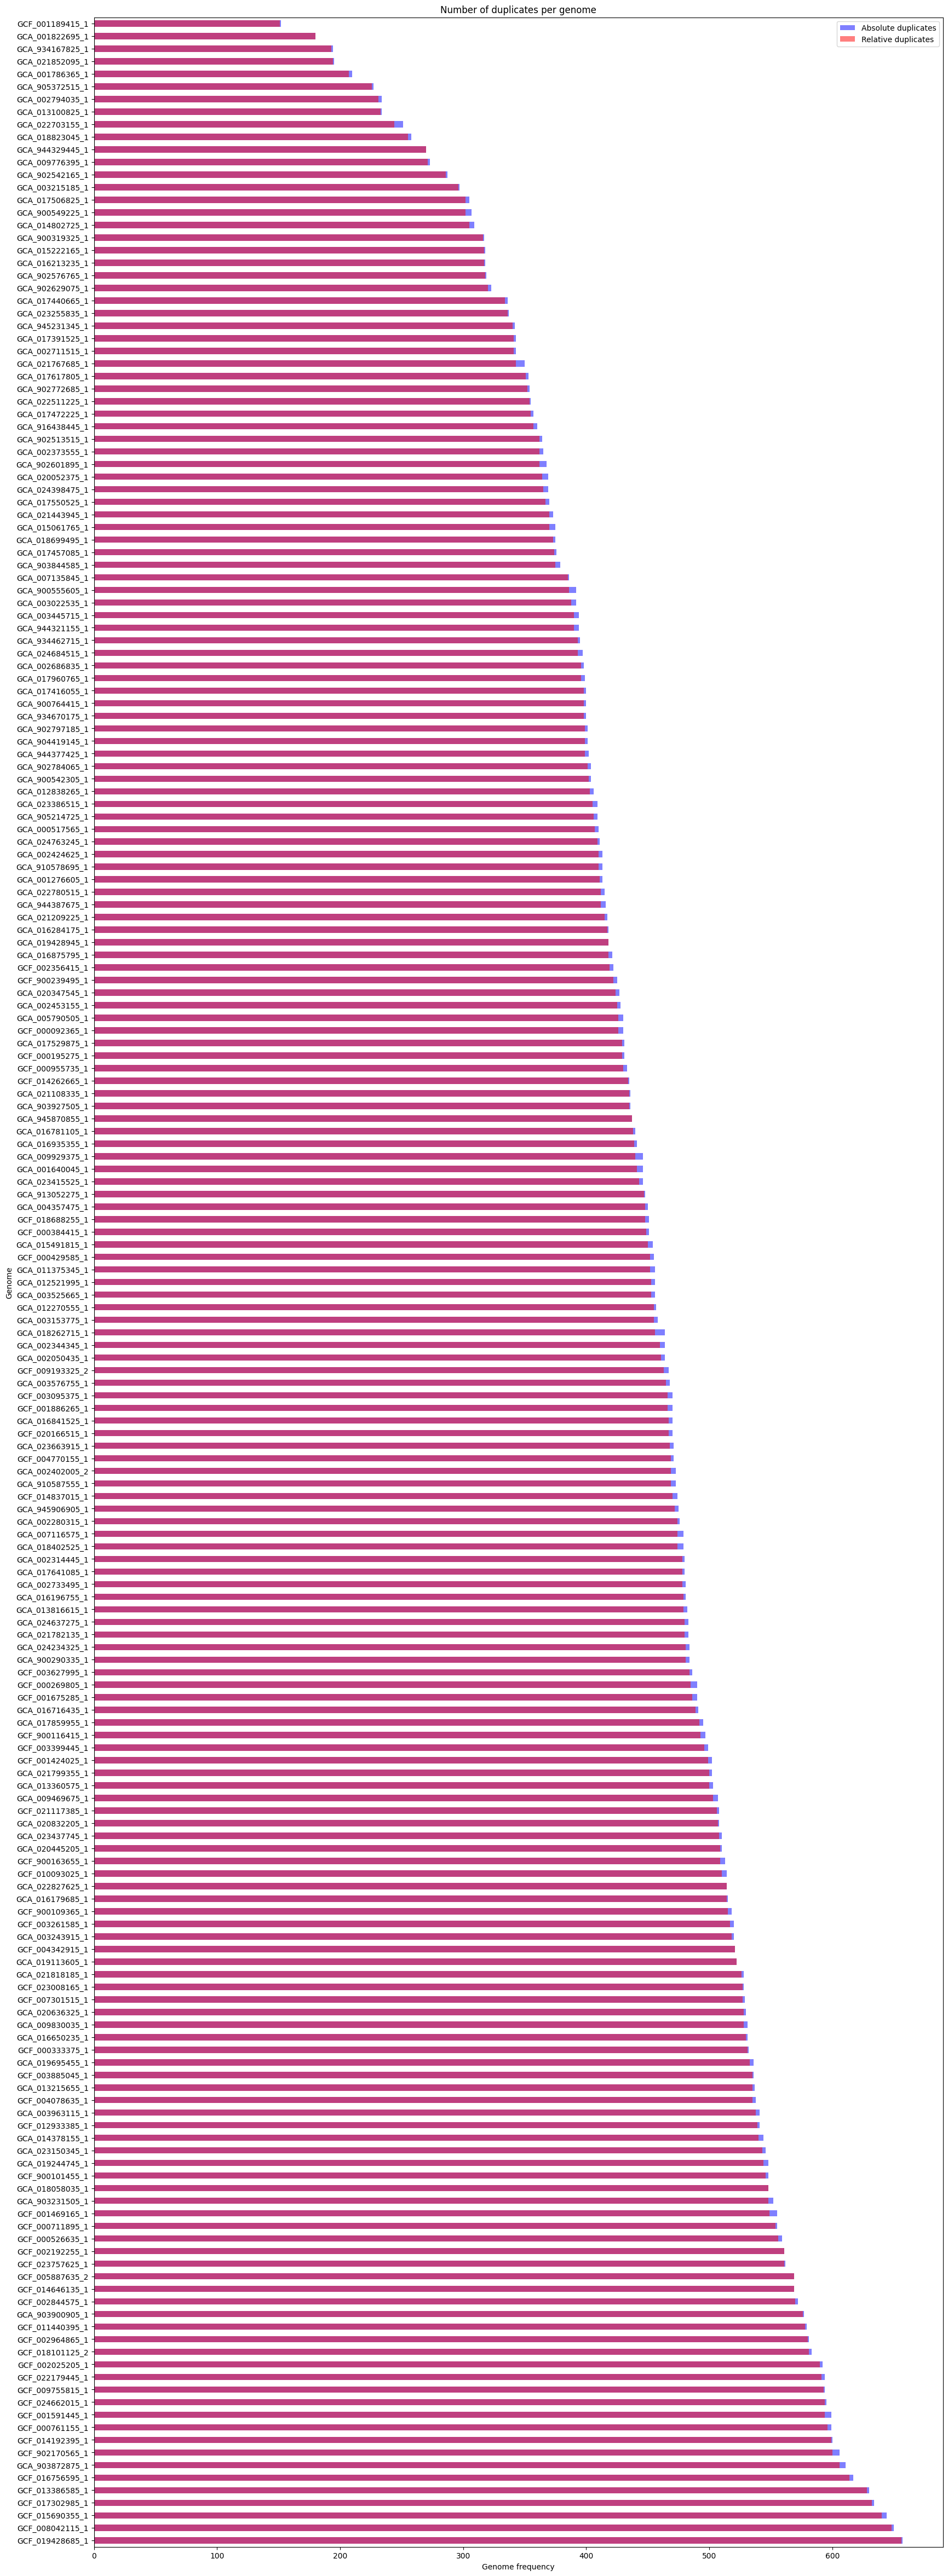

In [13]:
abs_genome_freq = abs_df['genome'].value_counts()
rel_genome_freq = rel_df['genome'].value_counts()

plot_duplicates(abs_genome_freq, rel_genome_freq)

- Question: how do we deal with genome duplicates?

In [14]:
# set of codons
amino_abs = set(abs_df.columns)
amino_rel = set(rel_df.columns)

amino_abs.difference(amino_rel)

{'ATG', 'TAA', 'TAG', 'TGA', 'TGG'}

- Question: 5 codons are missing in the relative data

In [15]:
# select only overlapping amino acids
amio_intersect = amino_rel.intersection(amino_abs)

# remove abundant features
vals = ['genome', 'source', 'accession', 'name']
for val in vals:
    amio_intersect.discard(val)

# select only counts
abs_counts = abs_df.loc[:, list(amio_intersect)]
rel_counts = rel_df.loc[:, list(amio_intersect)]

abs_counts.shape, rel_counts.shape

((90290, 59), (89767, 59))

- Question: why there are fewer genomes in relative data?

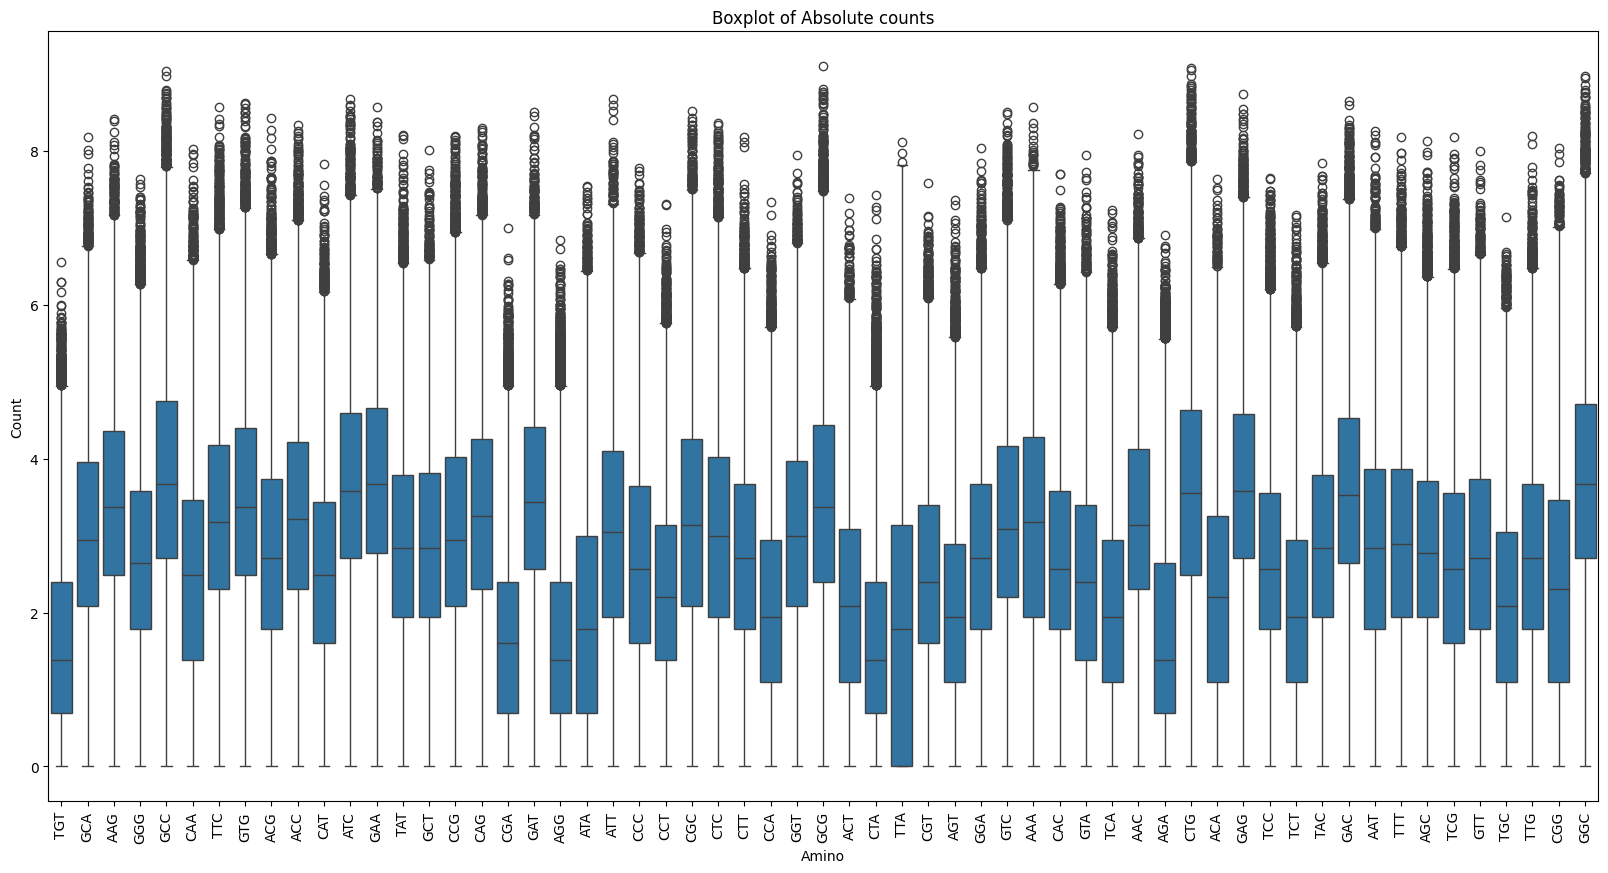

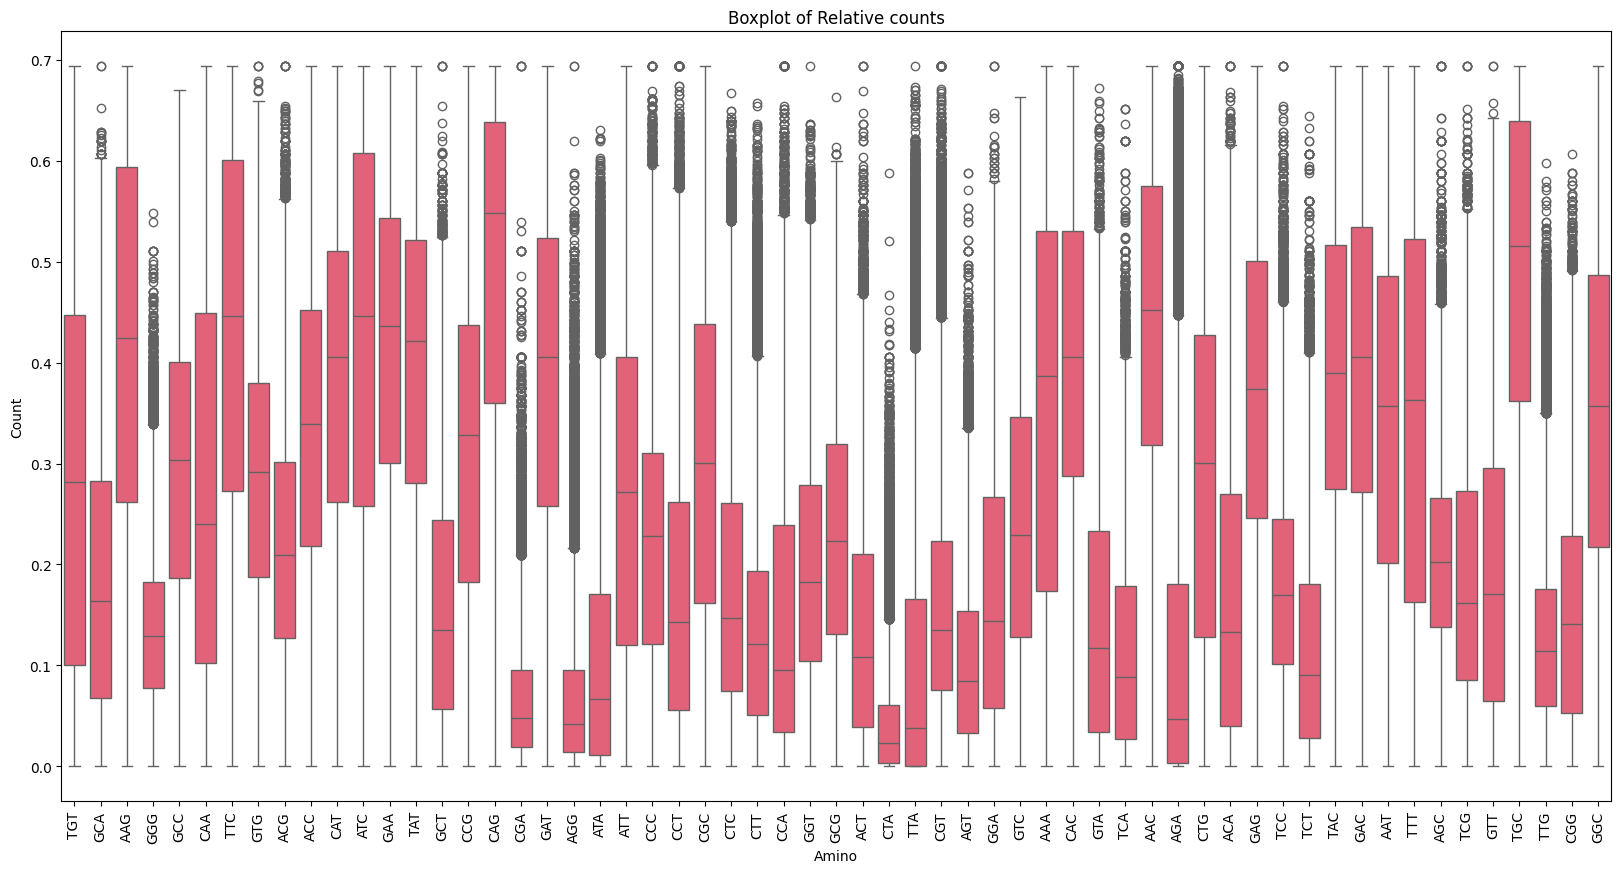

In [118]:
genome_boxplot(abs_counts, 'Boxplot of Absolute counts', '#1F77B4')
genome_boxplot(rel_counts, 'Boxplot of Relative counts', '#F74E6B')

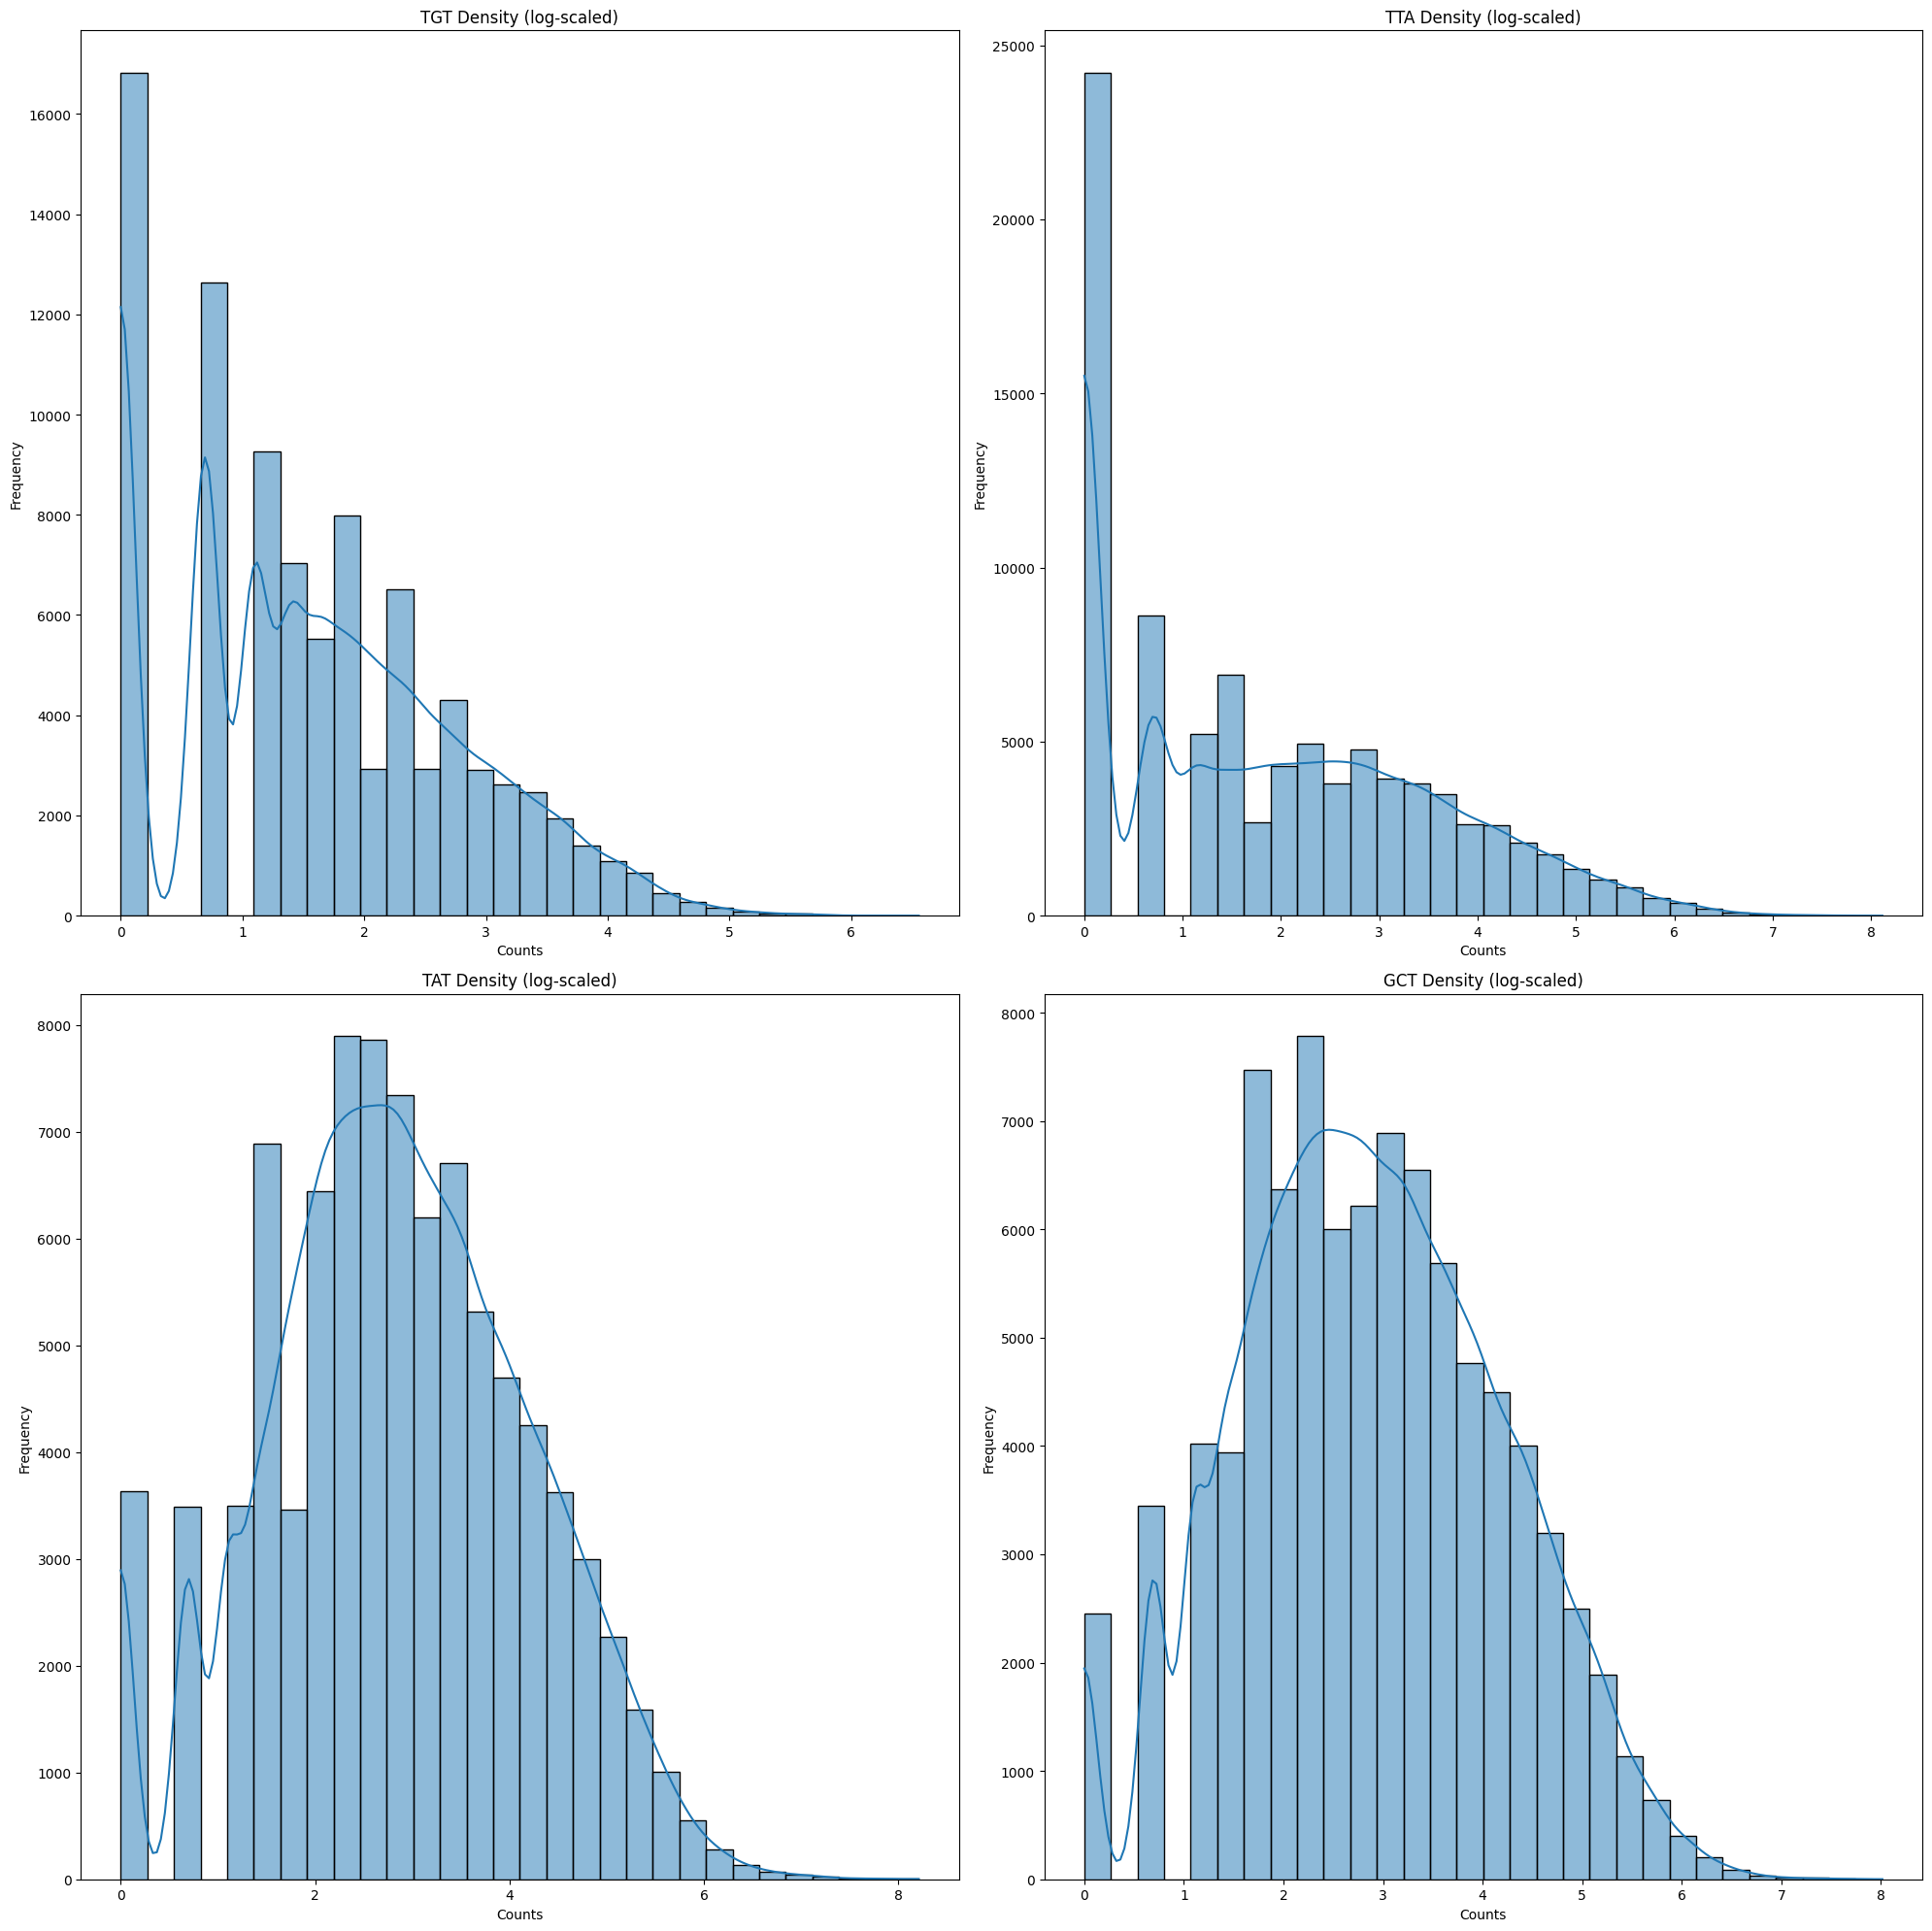

In [119]:
# check densities of some genomes
genes = ['TGT', 'TTA', 'TAT', 'GCT']

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for i, gene in enumerate(genes):
    row = i // 2
    col = i % 2
    plot_genome_density(abs_counts, gene, axs[row, col])

plt.tight_layout()
plt.show()

- Question: how would you explain TTA behaviour?

In [22]:
# pick the most frequent genome
top_genome_ix = abs_df[abs_df['genome'] == 'GCF_019428685_1'].index
len(top_genome_ix)

657

/Users/oleg.vlasovetc/opt/anaconda3/envs/anvio-dev/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


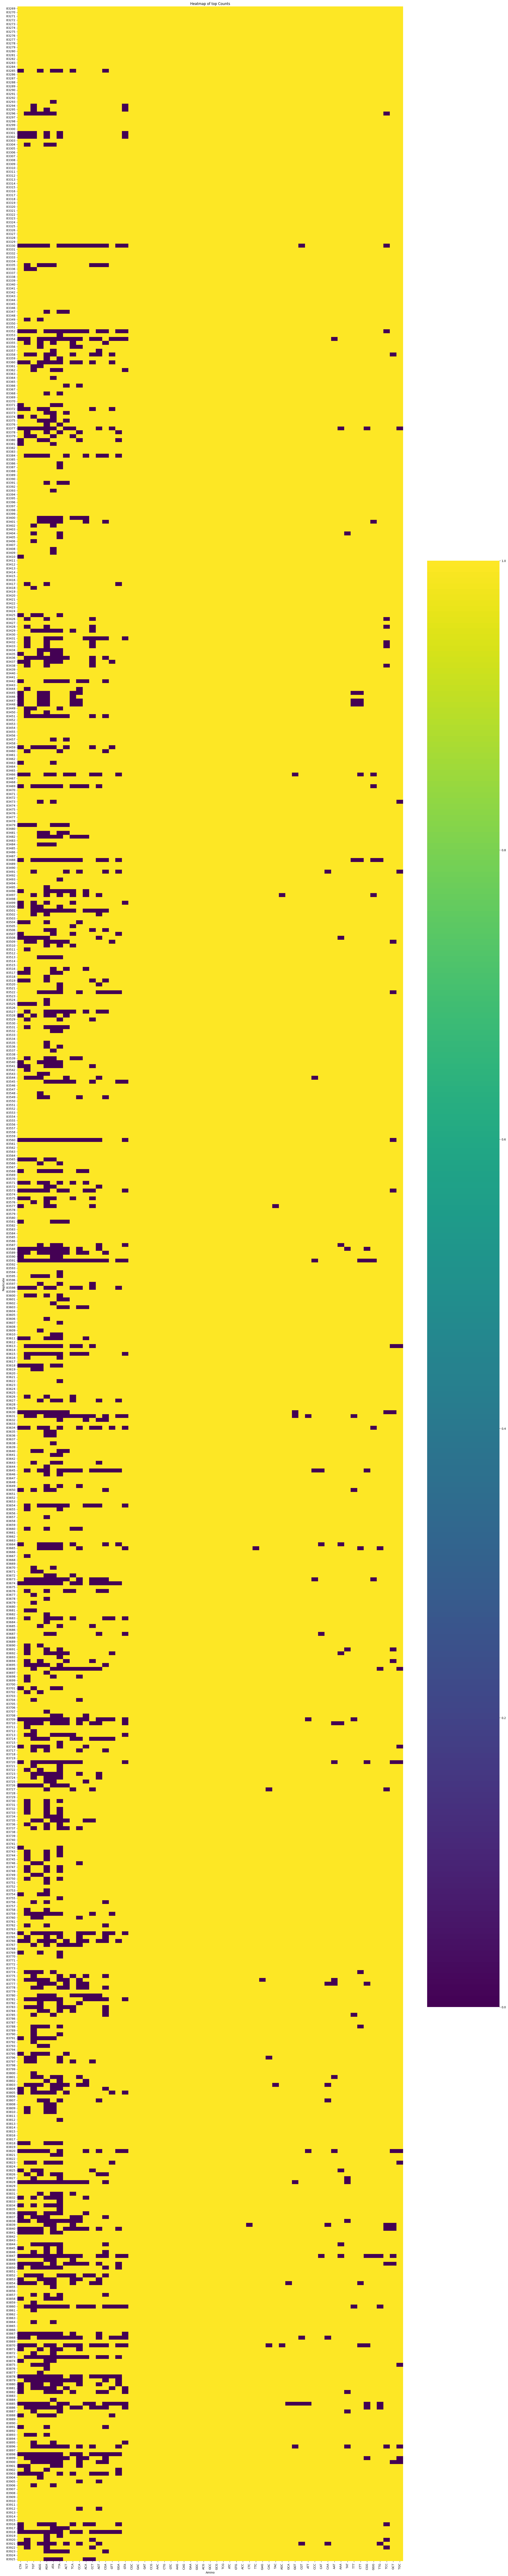

In [35]:
# binary top genome counts
top_counts = abs_counts.loc[top_genome_ix].astype(bool)

plot_clustermap(top_counts)

- Question: is it possible get the data on a individual gene level?

|           |         | TGT | GCA | AAG | ... | GGC |
|-----------|---------|-----|-----|-----|-----|-----|
| genome_1  | gene_1  |     |     |     |     |     |
|           | gene_2  |     |     |     |     |     |
|           | ...     |     |     |     |     |     |
|           | gene_n  |     |     |     |     |     |
| ...       | ...     |     |     |     |     |     |
|-----------|---------|-----|-----|-----|-----|-----|
| genome_k  | gene_1  |     |     |     |     |     |
|           | gene_2  |     |     |     |     |     |
|           | ...     |     |     |     |     |     |
|           | gene_p  |     |     |     |     |     |

# Genome analysis and simulations

In [2]:
abs_df = pd.read_csv('../data/d__Bacteria_absolute_freqs_genes.tsv', sep='\t', index_col=0)
rel_df = pd.read_csv('../data/d__Bacteria_rel_syn_freqs_genes.tsv', sep='\t', index_col=0)

abs_df.shape, rel_df.shape

((612347, 65), (612347, 60))

In [72]:
df_dict = {}

# read function annotations from Iva's tar file
with tarfile.open('../data/gtdb_functions.tar', 'r') as tar:

    for member in tar.getmembers():
        if member.isfile():
            f = tar.extractfile(member)

            df = pd.read_csv(f, delimiter='\t')
            
            member.name = member.name.split('/')[1].split('.')[0]
            df_dict[member.name] = df
            
df_dict.keys()

dict_keys(['GCA_017440665_1', 'GCA_023663915_1', 'GCA_016841525_1', 'GCA_016179685_1', 'GCA_016935355_1', 'GCA_018058035_1', 'GCA_000517565_1', 'GCA_016716435_1', 'GCA_020052375_1', 'GCA_016650235_1', 'GCF_019428685_1', 'GCA_002373555_1', 'GCA_021108335_1', 'GCA_902542165_1', 'GCF_001675285_1', 'GCA_002711515_1', 'GCA_902797185_1', 'GCF_002356415_1', 'GCF_002844575_1', 'GCA_021852095_1', 'GCA_910578695_1', 'GCA_001276605_1', 'GCA_945906905_1', 'GCA_001822695_1', 'GCF_002964865_1', 'GCA_003022535_1', 'GCF_022179445_1', 'GCA_003445715_1', 'GCA_002280315_1', 'GCA_016196755_1', 'GCA_002686835_1', 'GCA_002402005_2', 'GCA_013215655_1', 'GCA_020445205_1', 'GCF_004078635_1', 'GCA_012270555_1', 'GCA_902629075_1', 'GCA_003576755_1', 'GCF_900239495_1', 'GCF_000092365_1', 'GCA_023437745_1', 'GCA_934462715_1', 'GCA_014378155_1', 'GCA_900549225_1', 'GCF_000429585_1', 'GCA_903927505_1', 'GCF_023757625_1', 'GCA_015061765_1', 'GCF_002025205_1', 'GCA_903231505_1', 'GCA_944321155_1', 'GCA_021782135_1', '

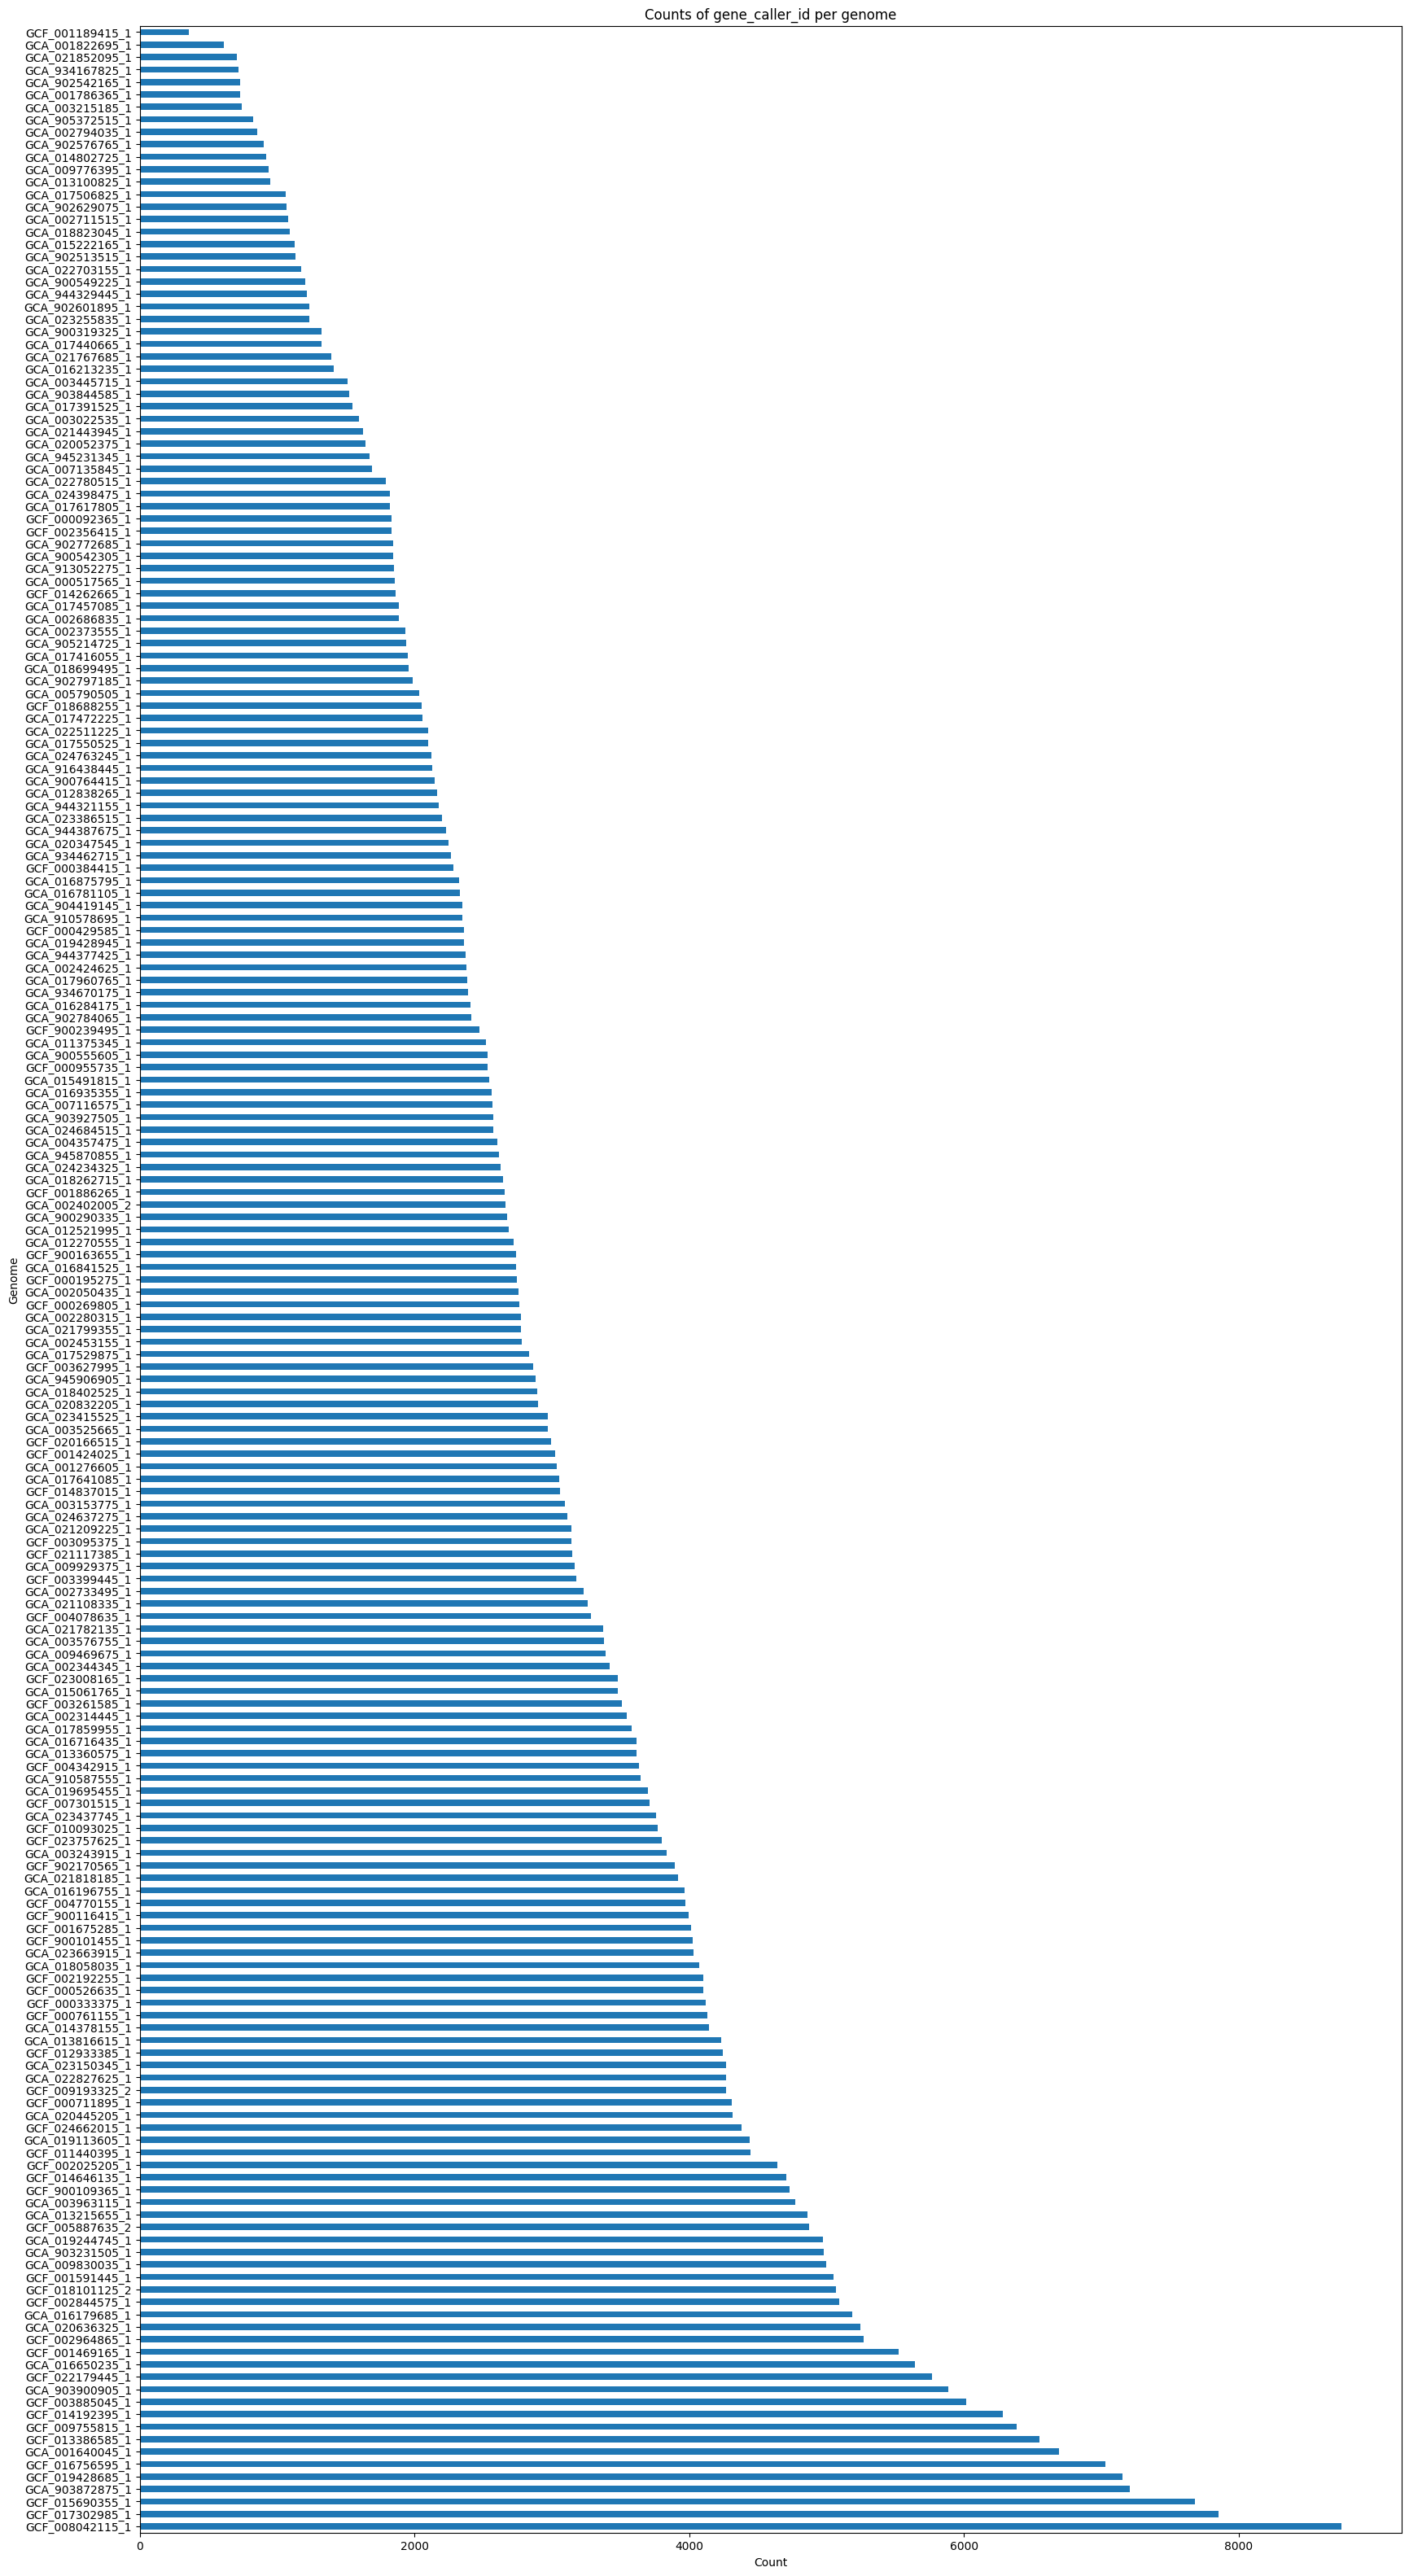

In [6]:
genes_counts = abs_df.groupby(abs_df.index)['gene_caller_id'].nunique()

sorted_genes_counts = genes_counts.sort_values(ascending=False)

plt.figure(figsize=(20, 40))

sorted_genes_counts.plot(kind='barh')

# Set the title and labels
plt.title('Counts of gene_caller_id per genome')
plt.ylabel('Genome')
plt.xlabel('Count')

# Show the plot
plt.show()

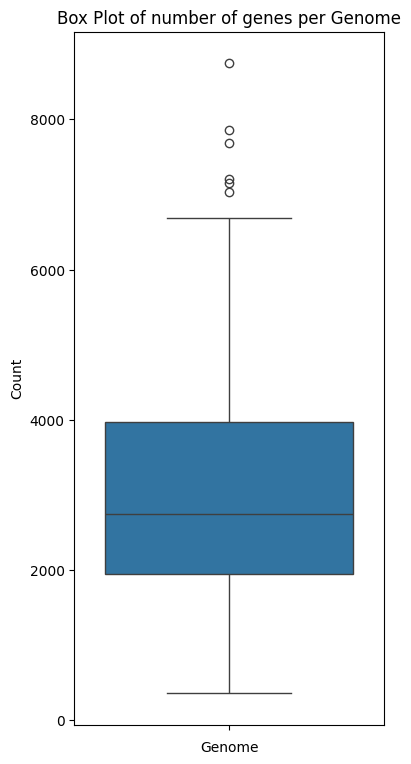

In [7]:
plt.figure(figsize=(4, 9))

# Create a box plot
sns.boxplot(data=sorted_genes_counts)

# Set the title and labels
plt.title('Box Plot of number of genes per Genome')
plt.xlabel('Genome')
plt.ylabel('Count')

# Show the plot
plt.show()

In [8]:
codon_names = [col for col in abs_df.columns if len(col) == 3]

print("Number of codons: {0}".format(len(codon_names)))

Number of codons: 64


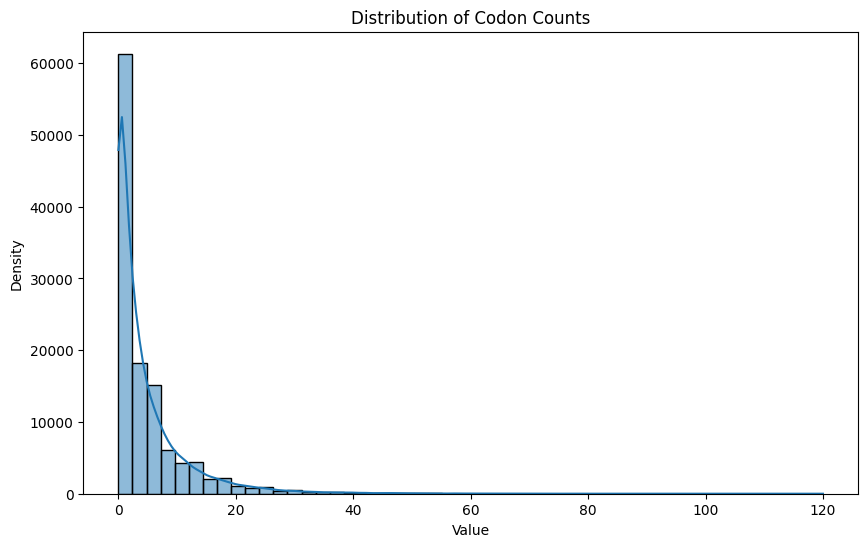

In [9]:
sel_genome = abs_df.loc['GCA_000517565_1']

# Flatten the dataframe to a 1D array
codon_counts = sel_genome[codon_names].values.flatten()

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the distribution of data
sns.histplot(codon_counts, bins=50, kde=True)

# Set the title and labels
plt.title('Distribution of Codon Counts')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()

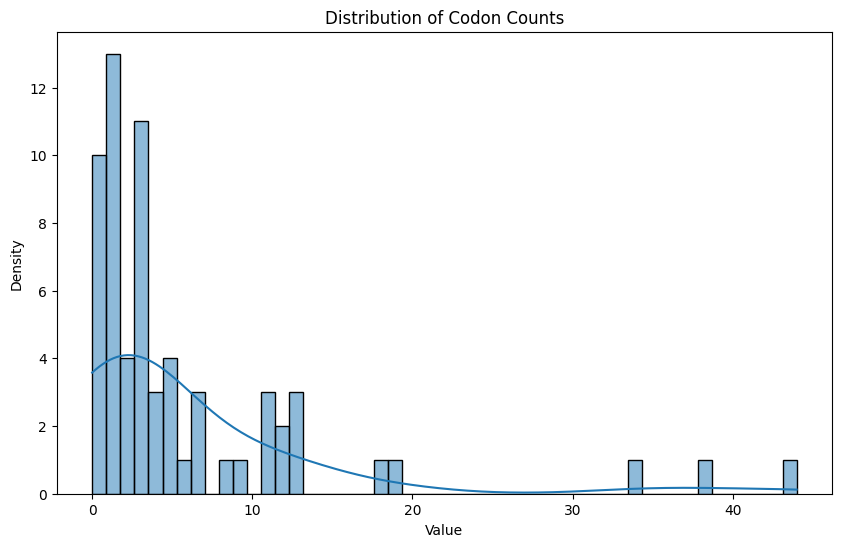

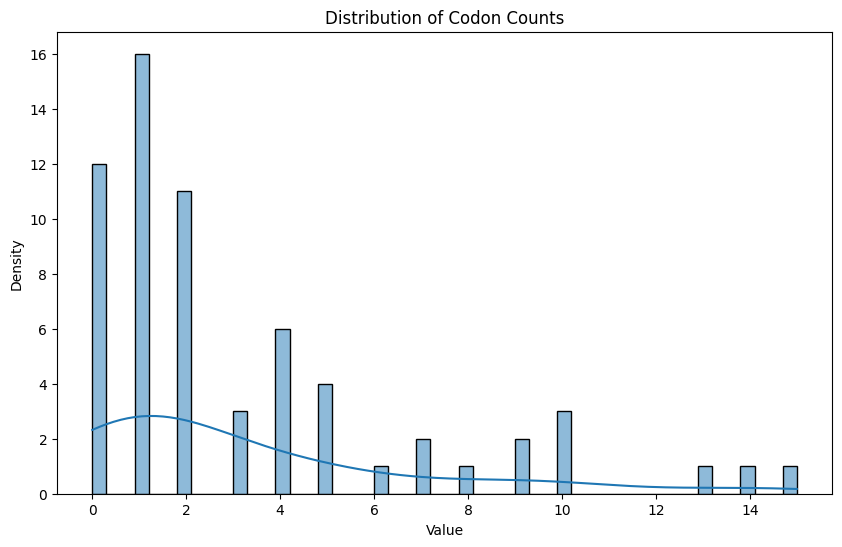

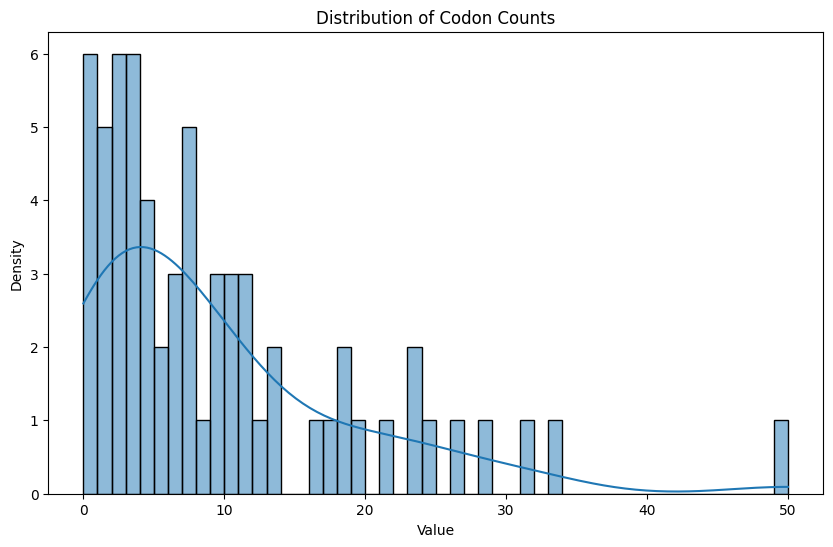

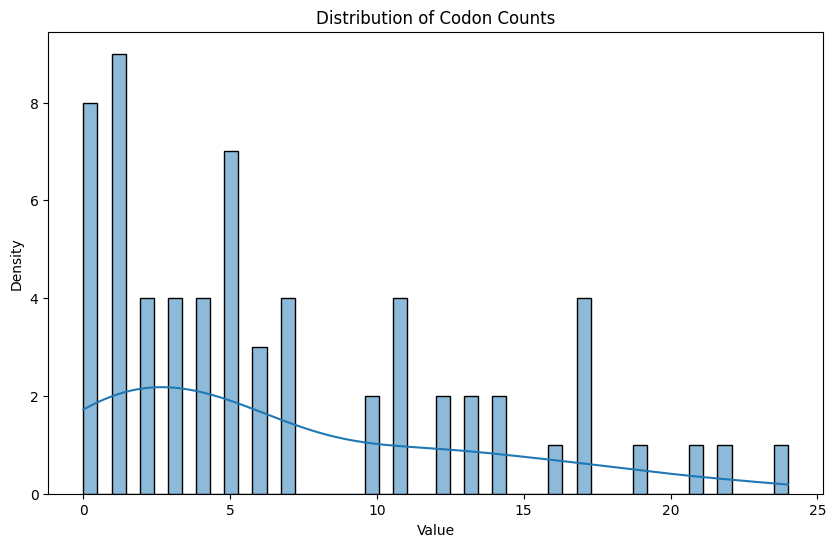

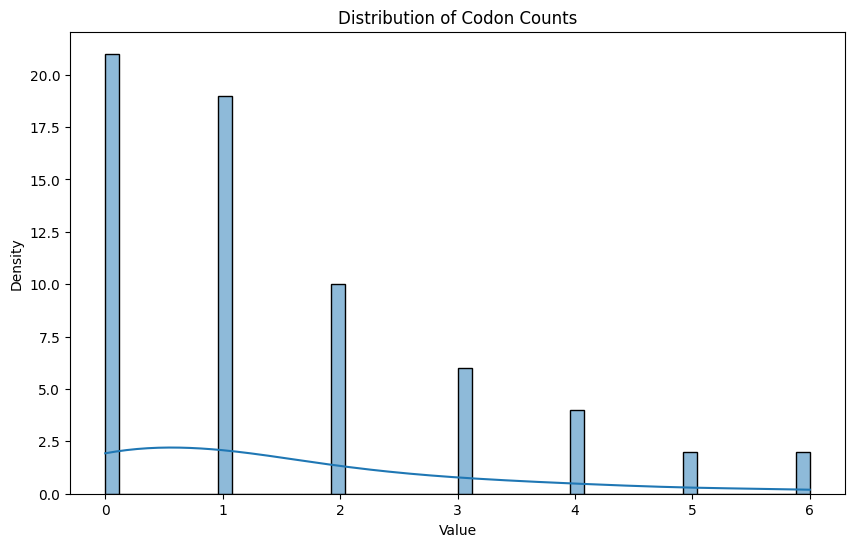

In [10]:
for gene in [0, 10, 200, 300, 500]:
    rand_gene = sel_genome[codon_names].iloc[gene, :]

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot the distribution of data
    sns.histplot(rand_gene, bins=50, kde=True)

    # Set the title and labels
    plt.title('Distribution of Codon Counts')
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Show the plot
    plt.show()

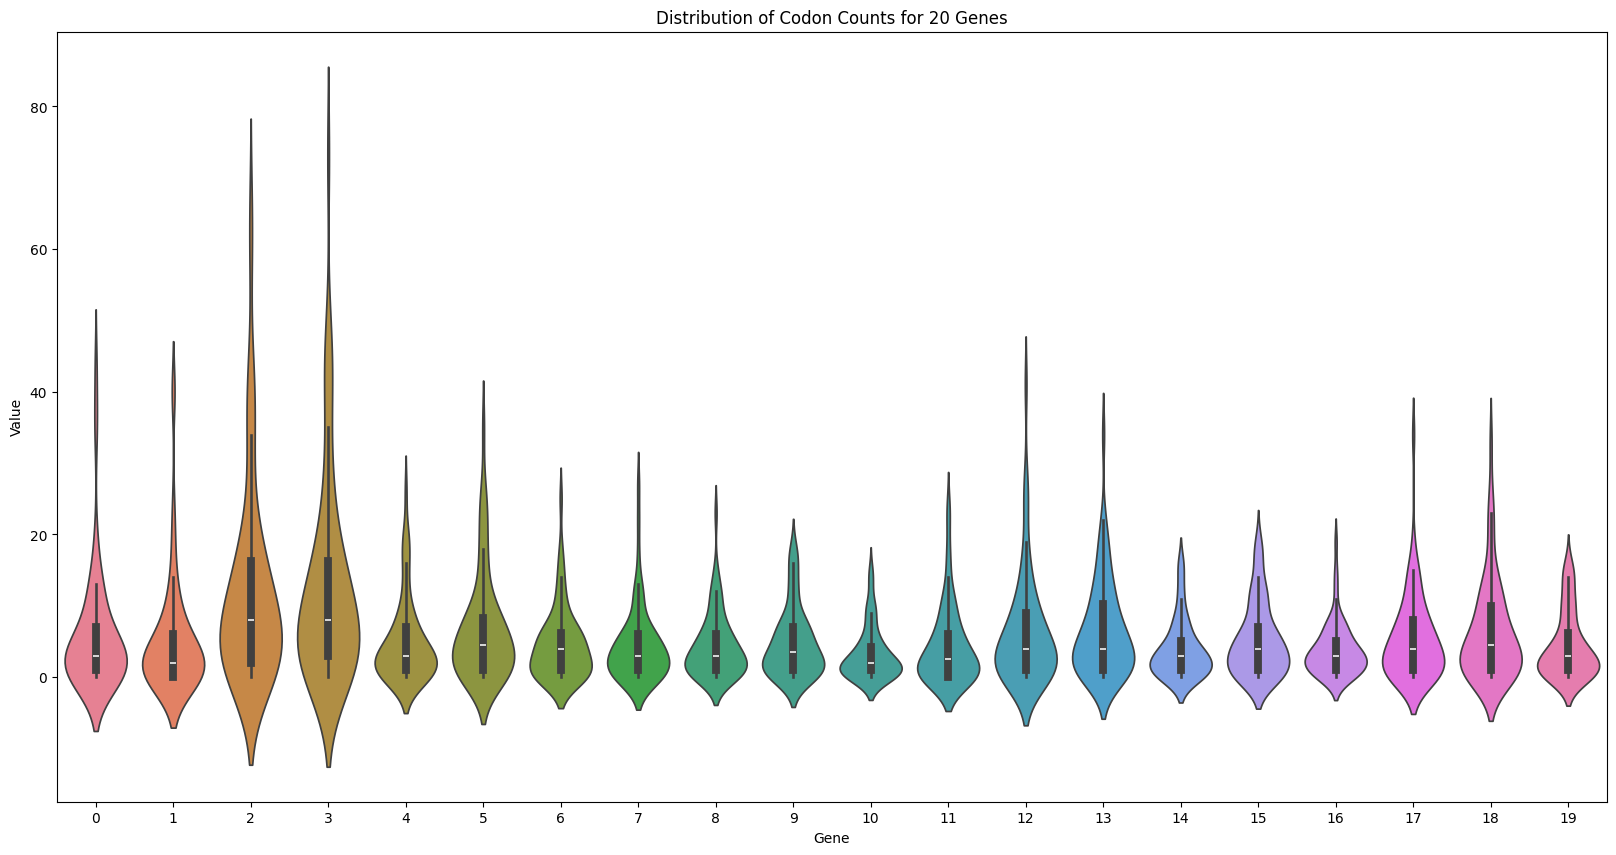

In [11]:
# Transpose the dataframe so that each gene is a column
genome_copy = sel_genome.copy()
genome_copy.reset_index(drop=True, inplace=True)

df_transposed = genome_copy[codon_names].iloc[:20, :].transpose()

# Create a new figure
plt.figure(figsize=(20, 10))

# Plot the distribution of data
sns.violinplot(data=df_transposed)

# Set the title and labels
plt.title('Distribution of Codon Counts for 20 Genes')
plt.xlabel('Gene')
plt.ylabel('Value')

# Show the plot
plt.show()

The distribution of genes look skewed to the left, so we could fit (zero-inflated) negative binomial model

Index(['GCA_003445715_1', 'GCA_021767685_1', 'GCF_004342915_1',
       'GCF_004078635_1', 'GCF_015690355_1', 'GCA_020636325_1',
       'GCA_020052375_1', 'GCA_934167825_1', 'GCA_022780515_1',
       'GCA_002424625_1'],
      dtype='object', name='genome')

In [44]:
min_index = sorted_genes_counts.idxmin()
max_index = sorted_genes_counts.idxmax()

median_value = sorted_genes_counts.median()
diff = abs(sorted_genes_counts - median_value)
median_index = diff.idxmin()

rnd_genomes_idx = list(sorted_genes_counts.sample(n=10).index)

print(f"Index of minimal value: {min_index}")
print(f"Index of maximal value: {max_index}")
print(f"Median value: {median_index}")
print(f"Random genomes: {rnd_genomes_idx}")

Index of minimal value: GCF_001189415_1
Index of maximal value: GCF_008042115_1
Median value: GCF_000195275_1
Random genomes: ['GCA_903927505_1', 'GCA_916438445_1', 'GCA_016196755_1', 'GCA_012838265_1', 'GCF_001189415_1', 'GCA_016781105_1', 'GCA_002344345_1', 'GCA_024763245_1', 'GCA_002050435_1', 'GCA_016213235_1']


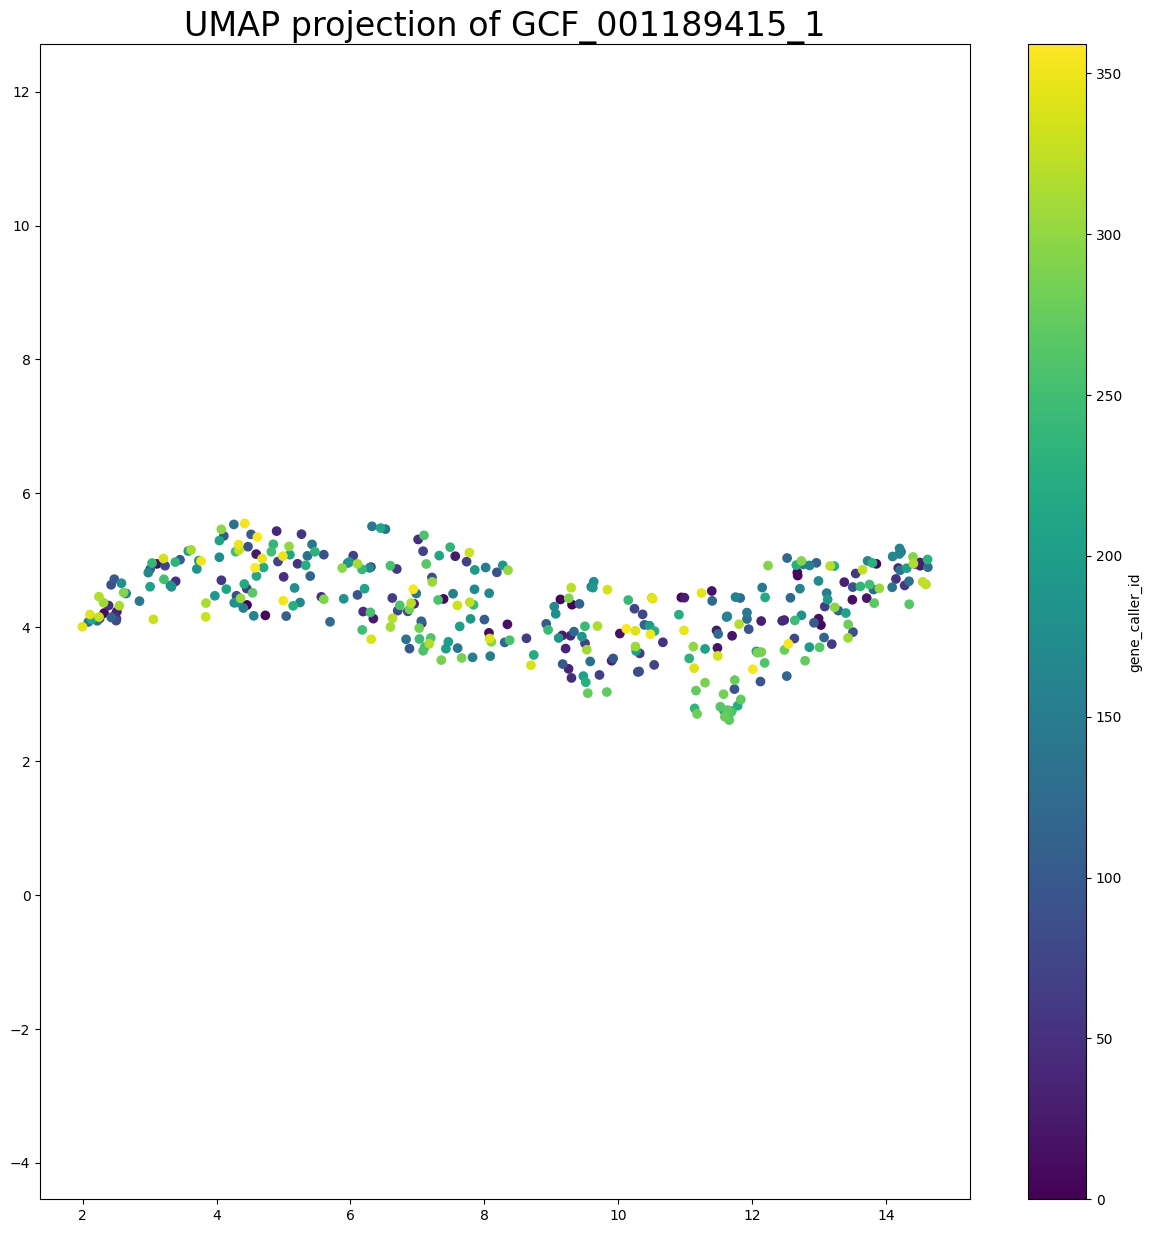

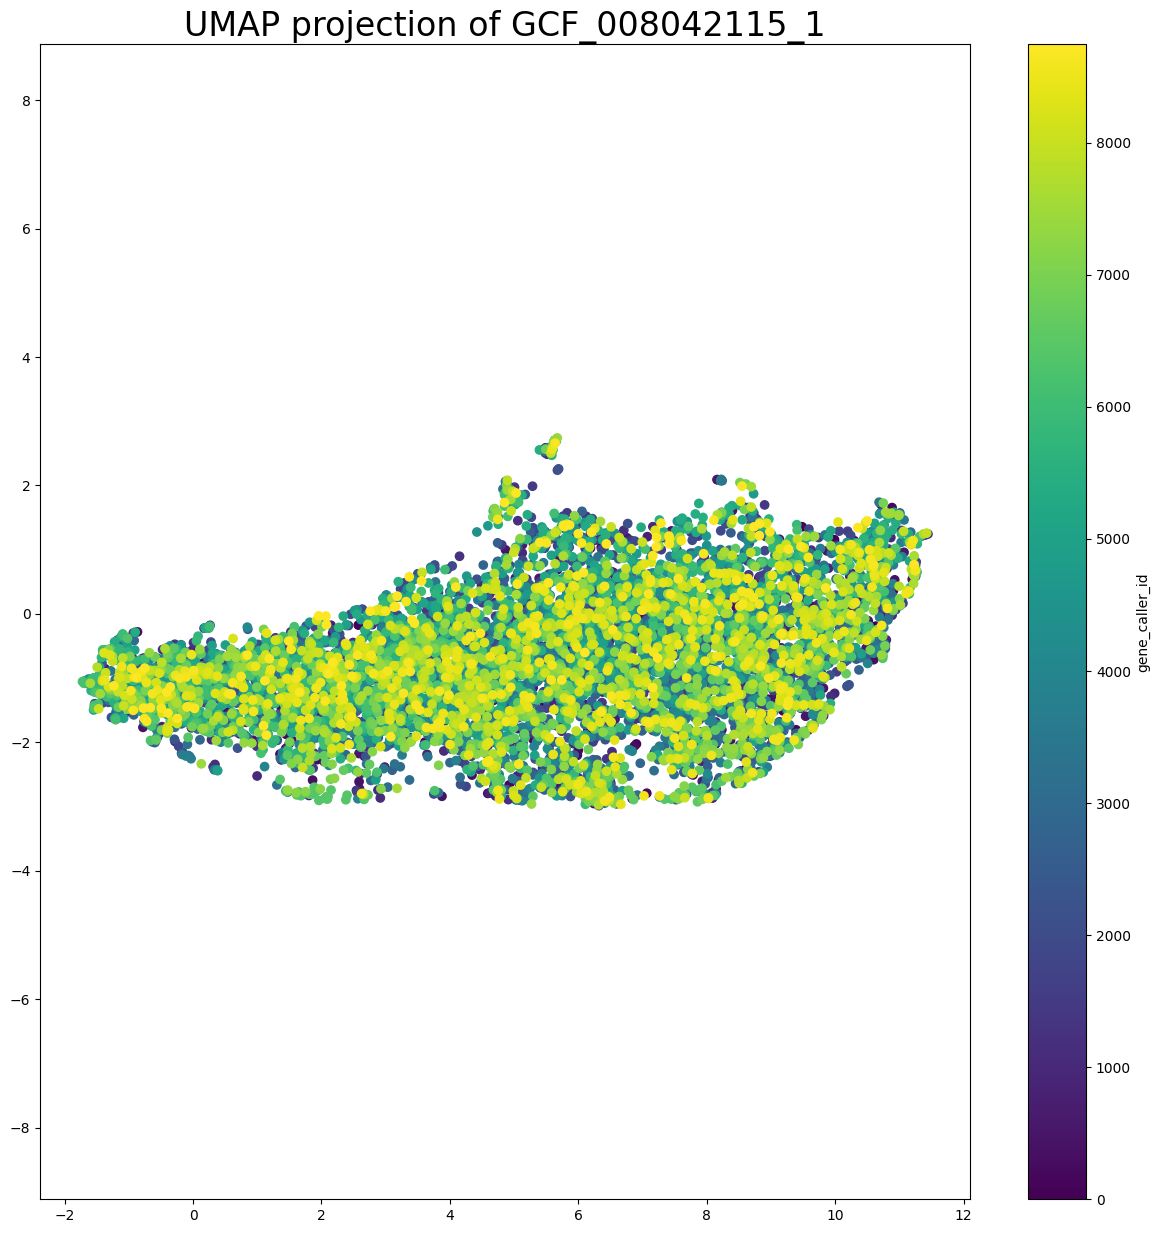

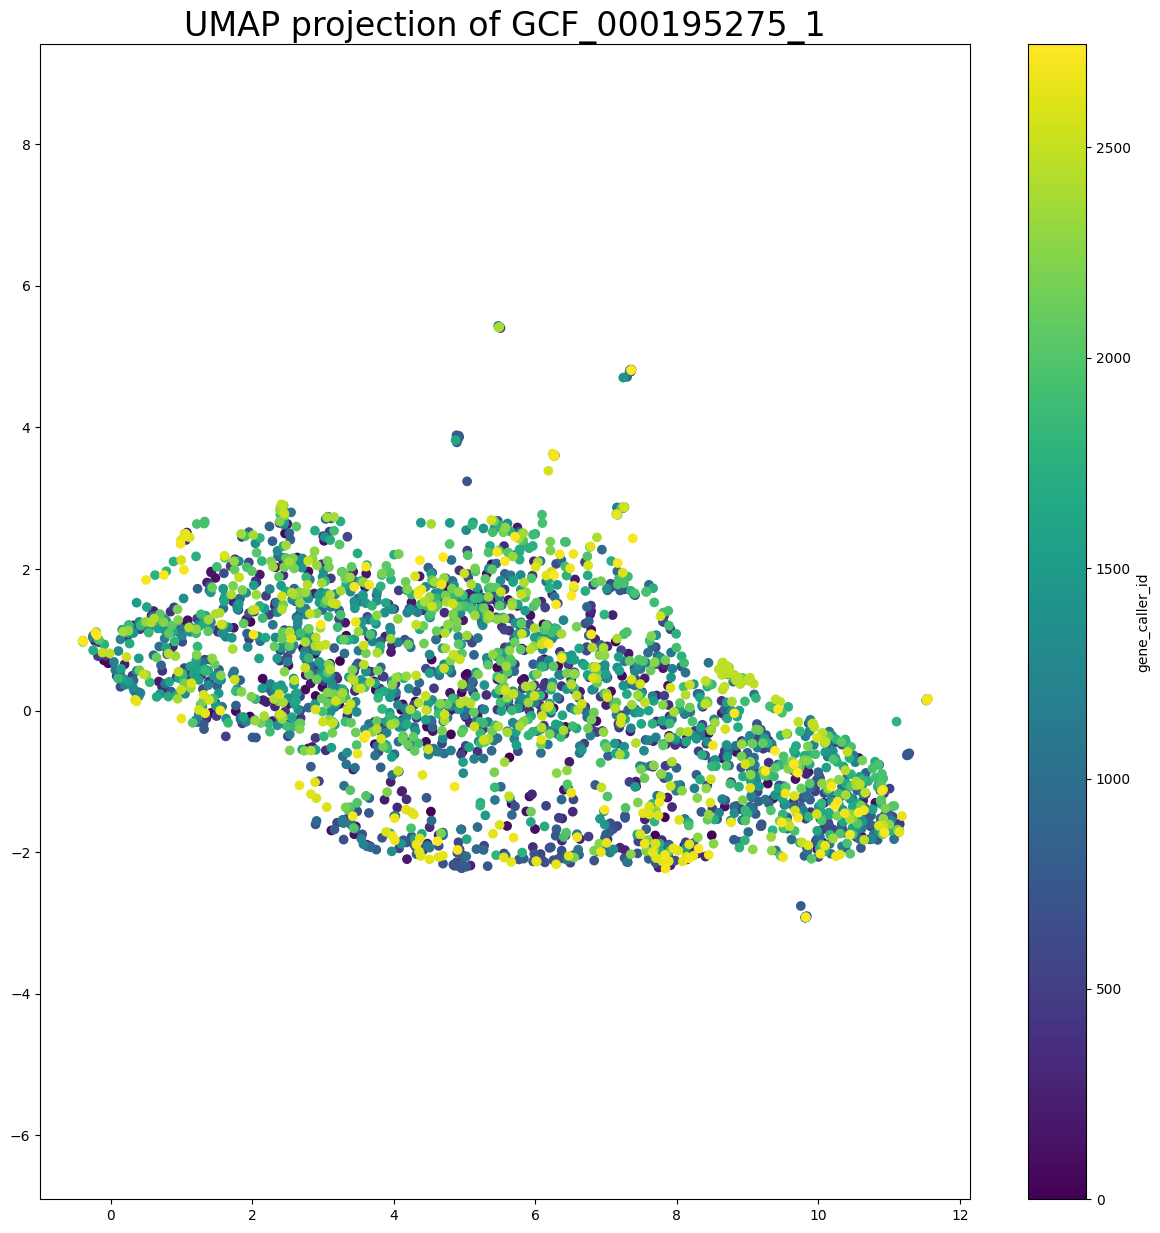

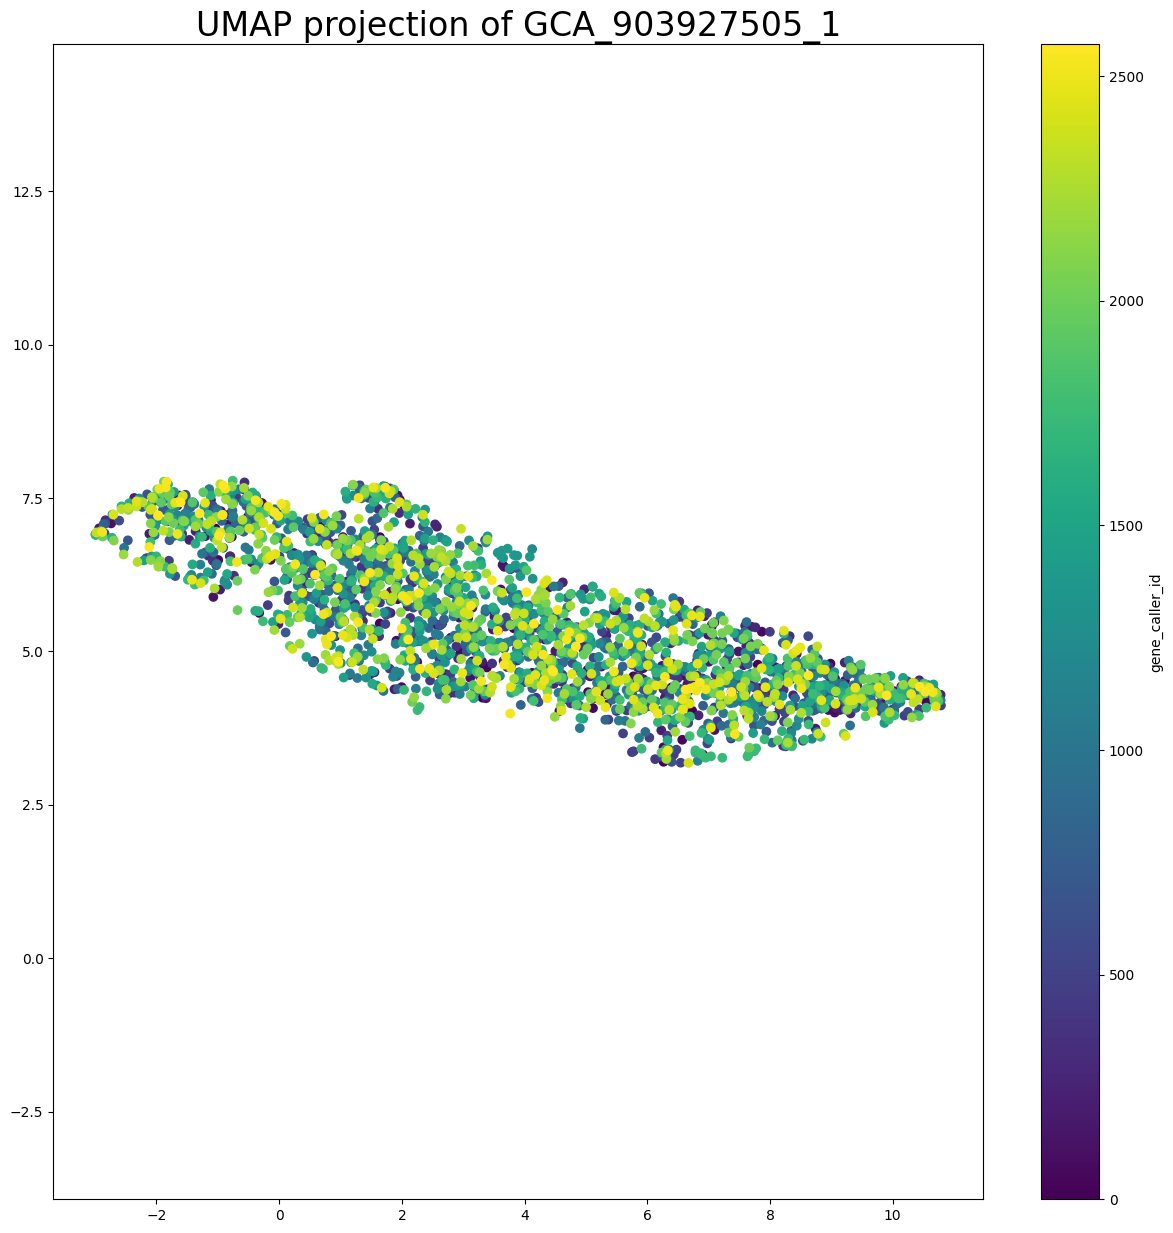

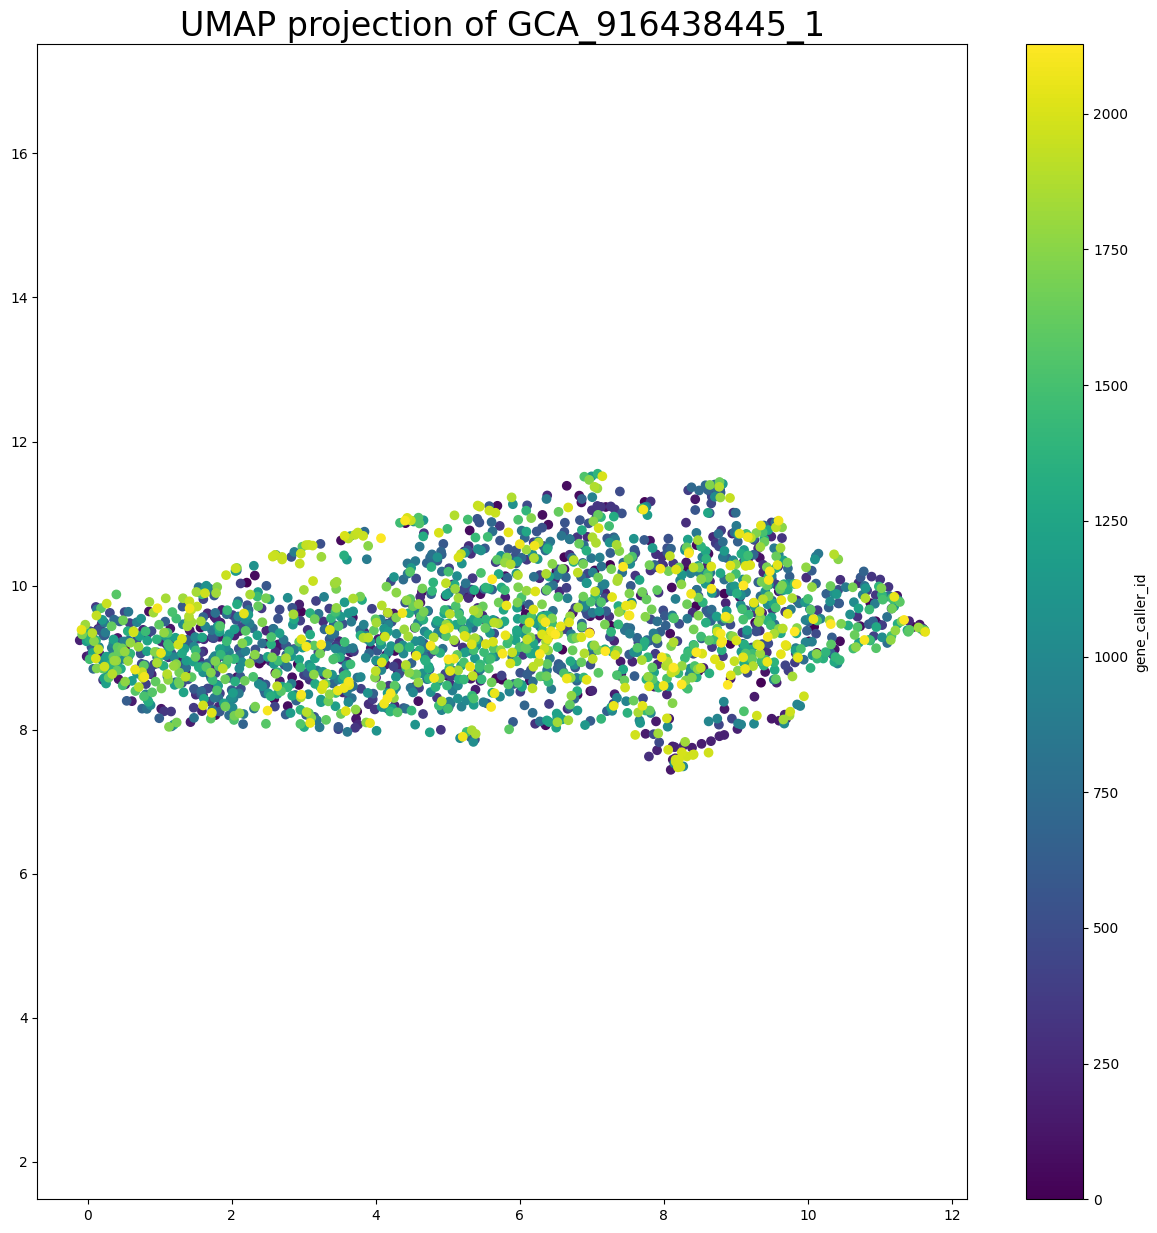

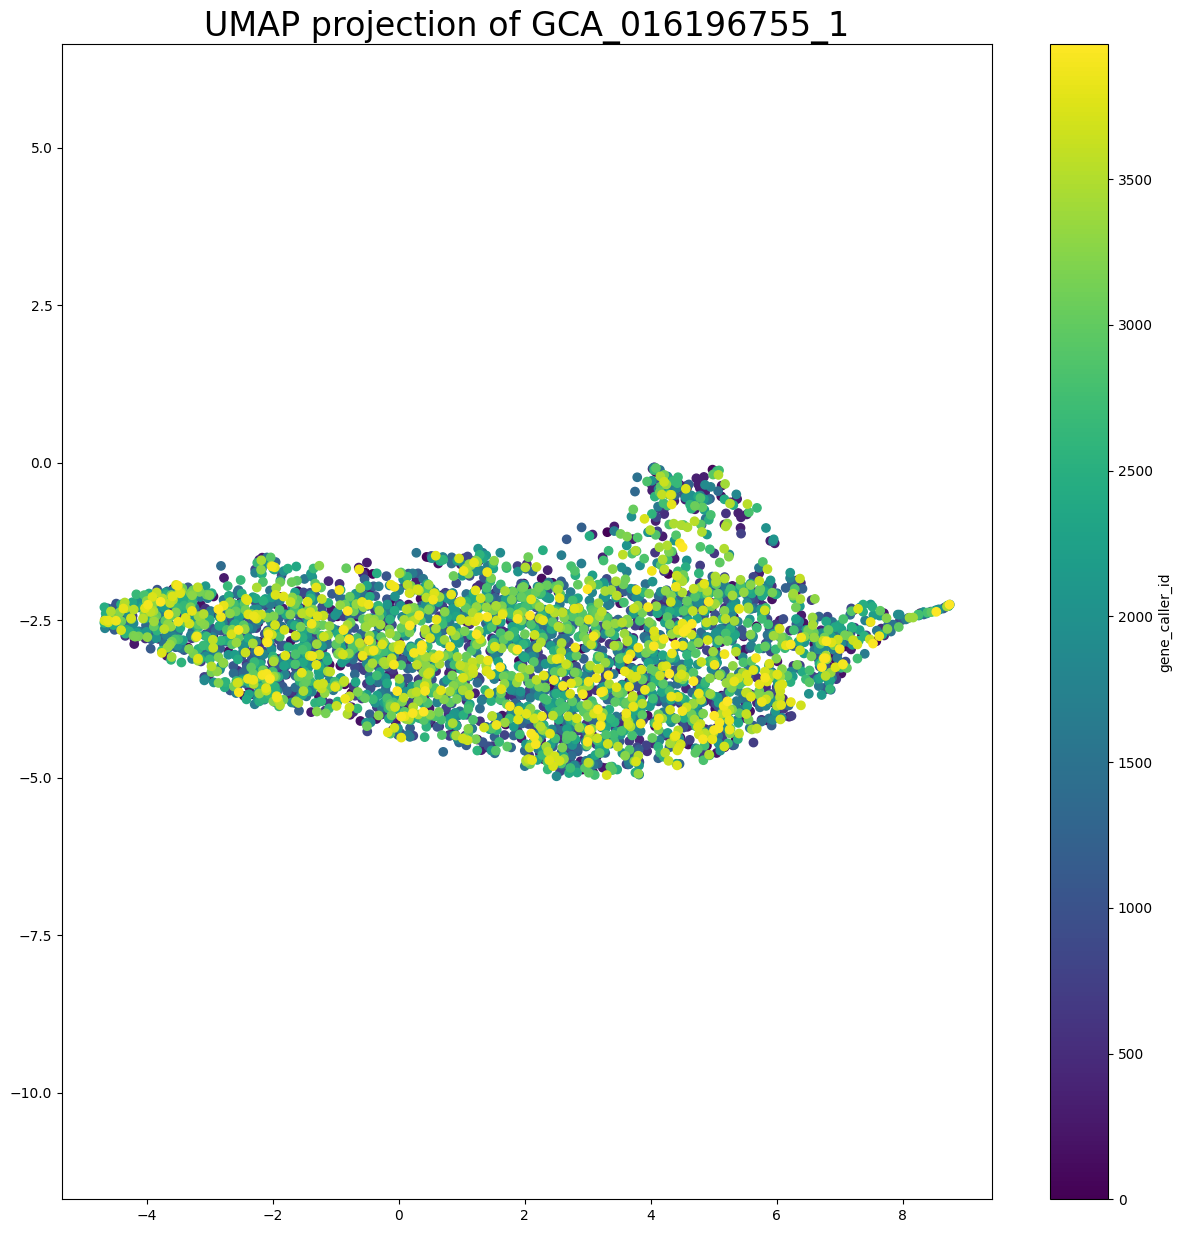

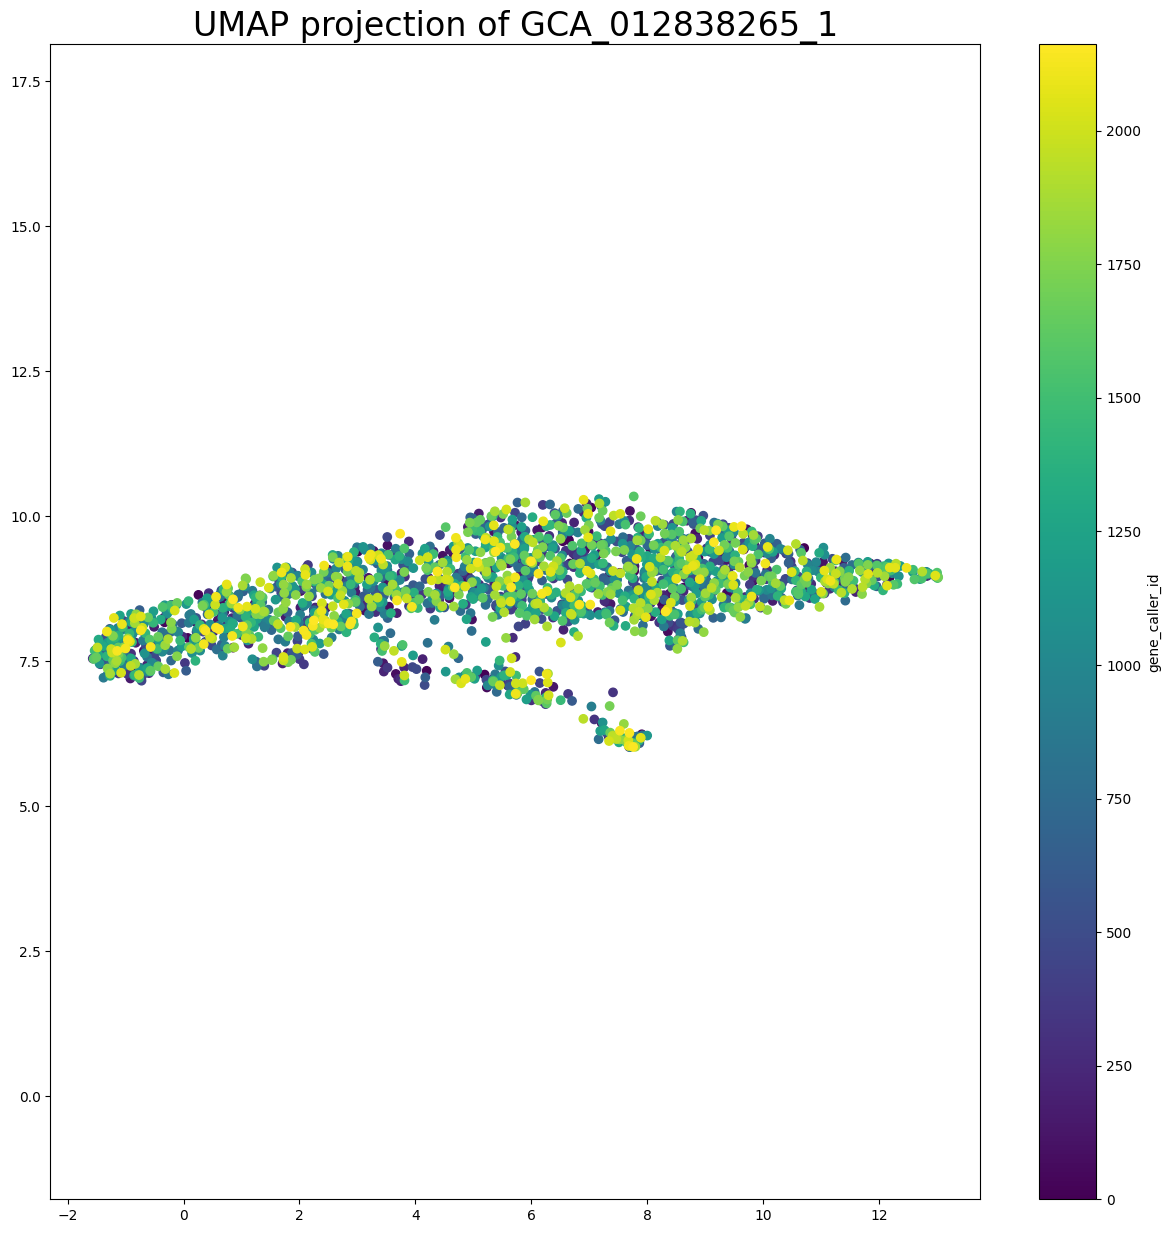

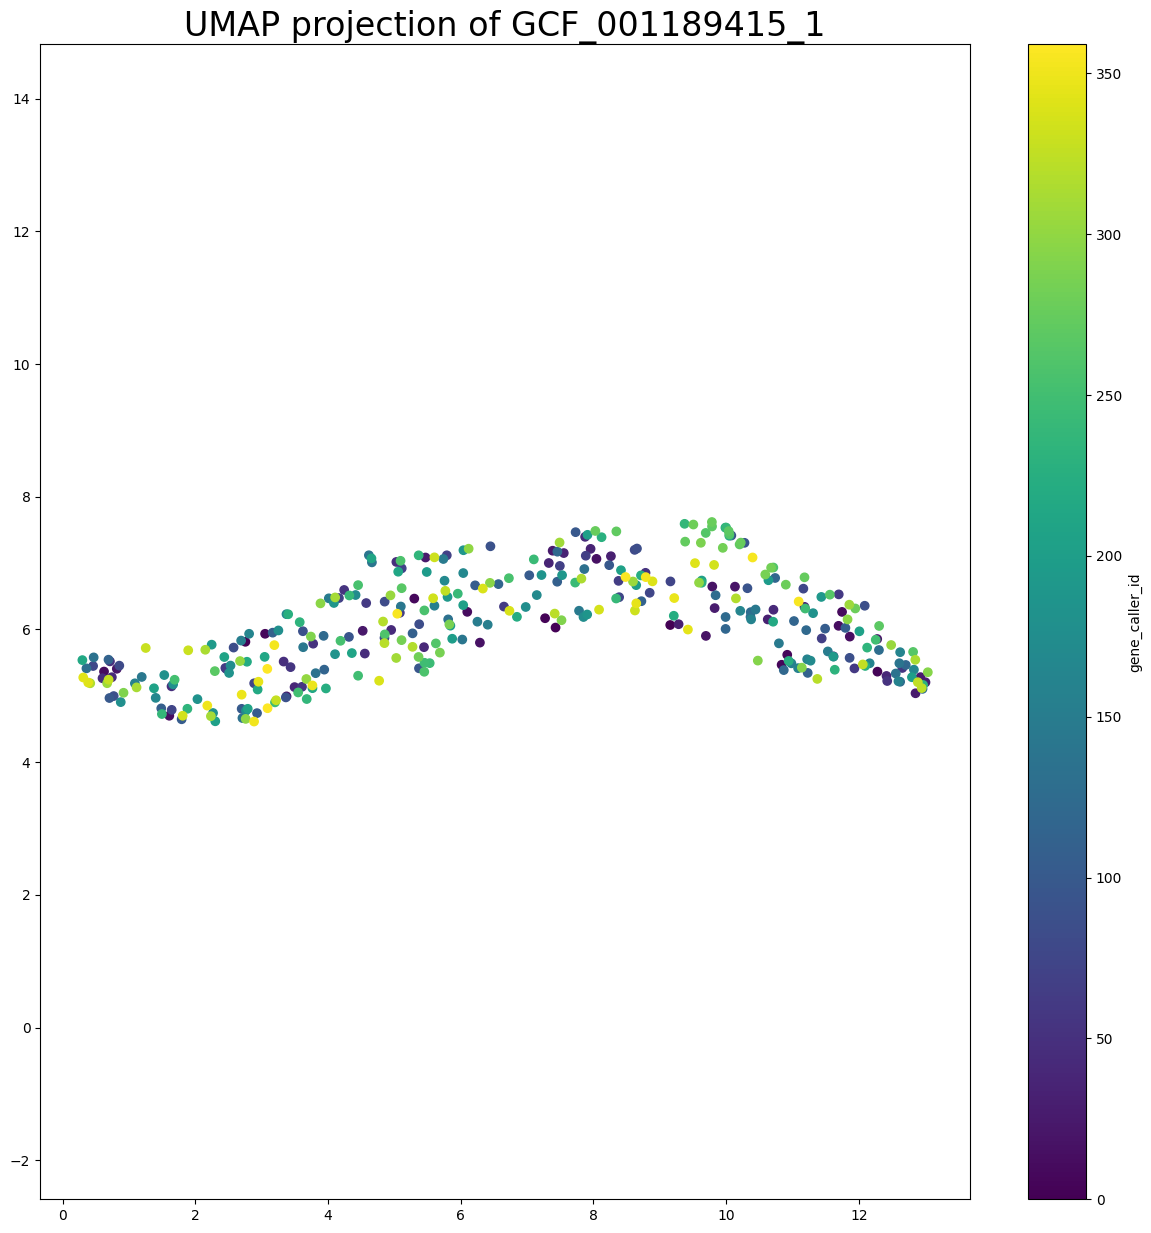

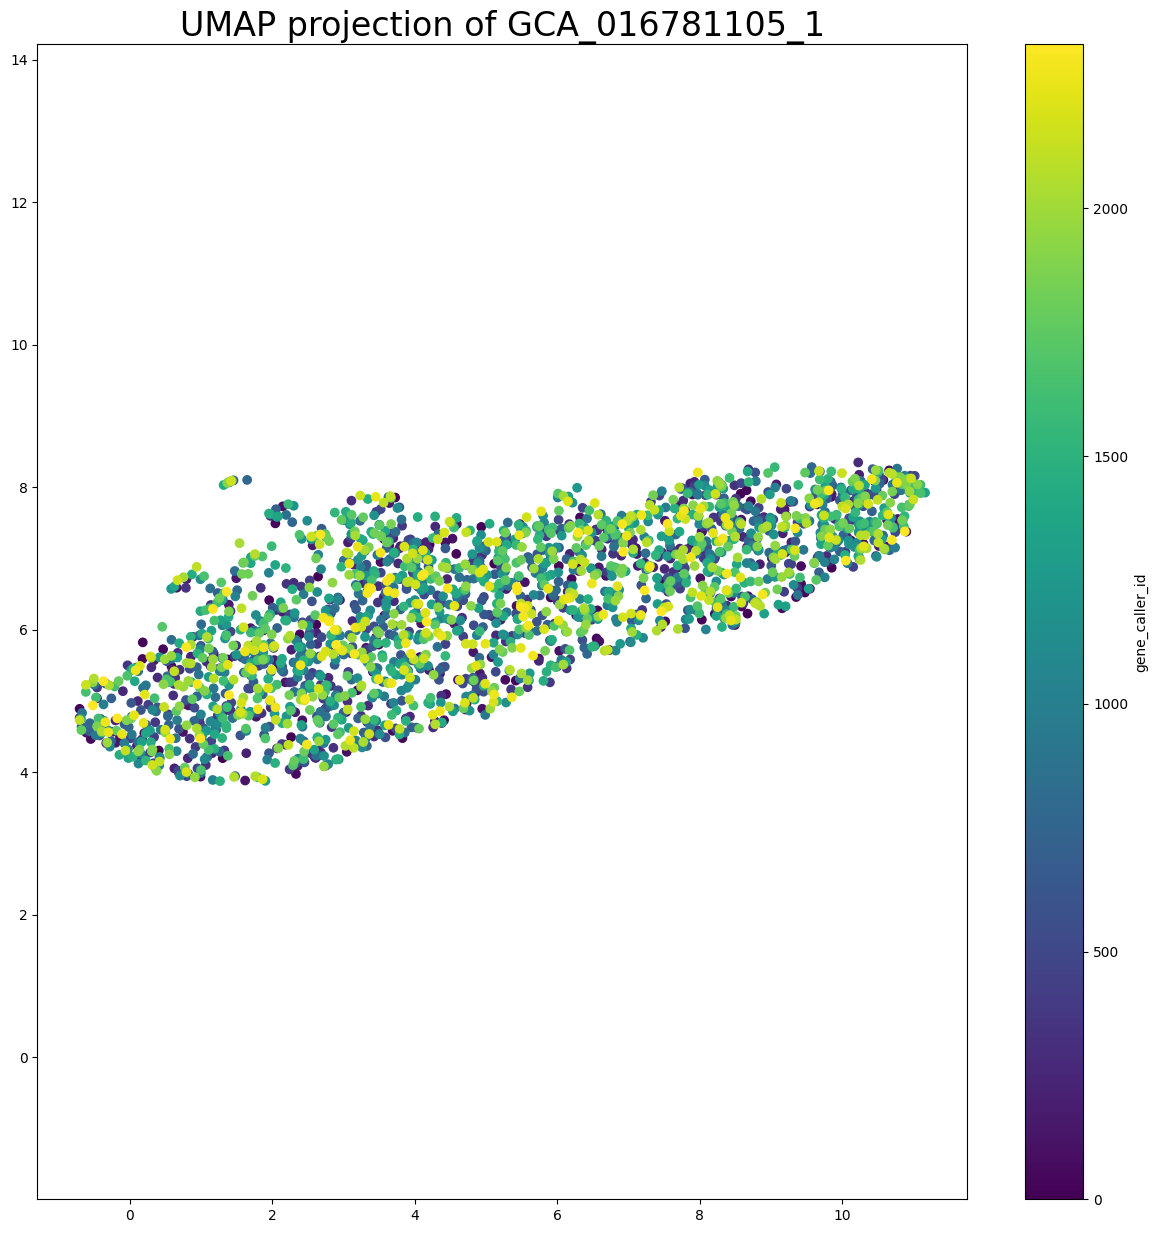

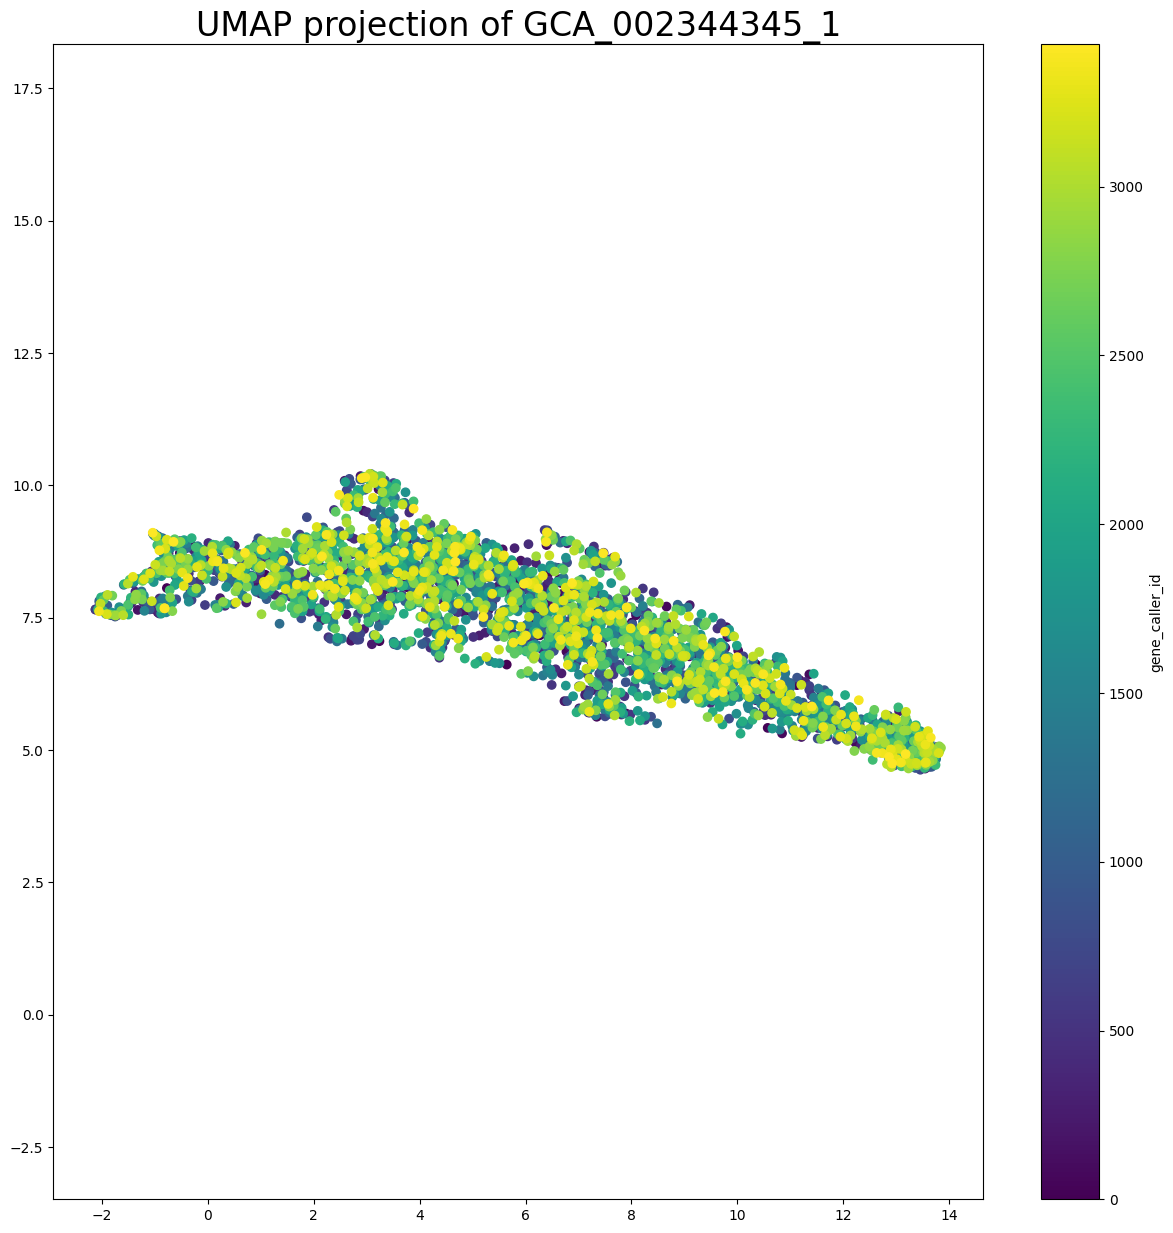

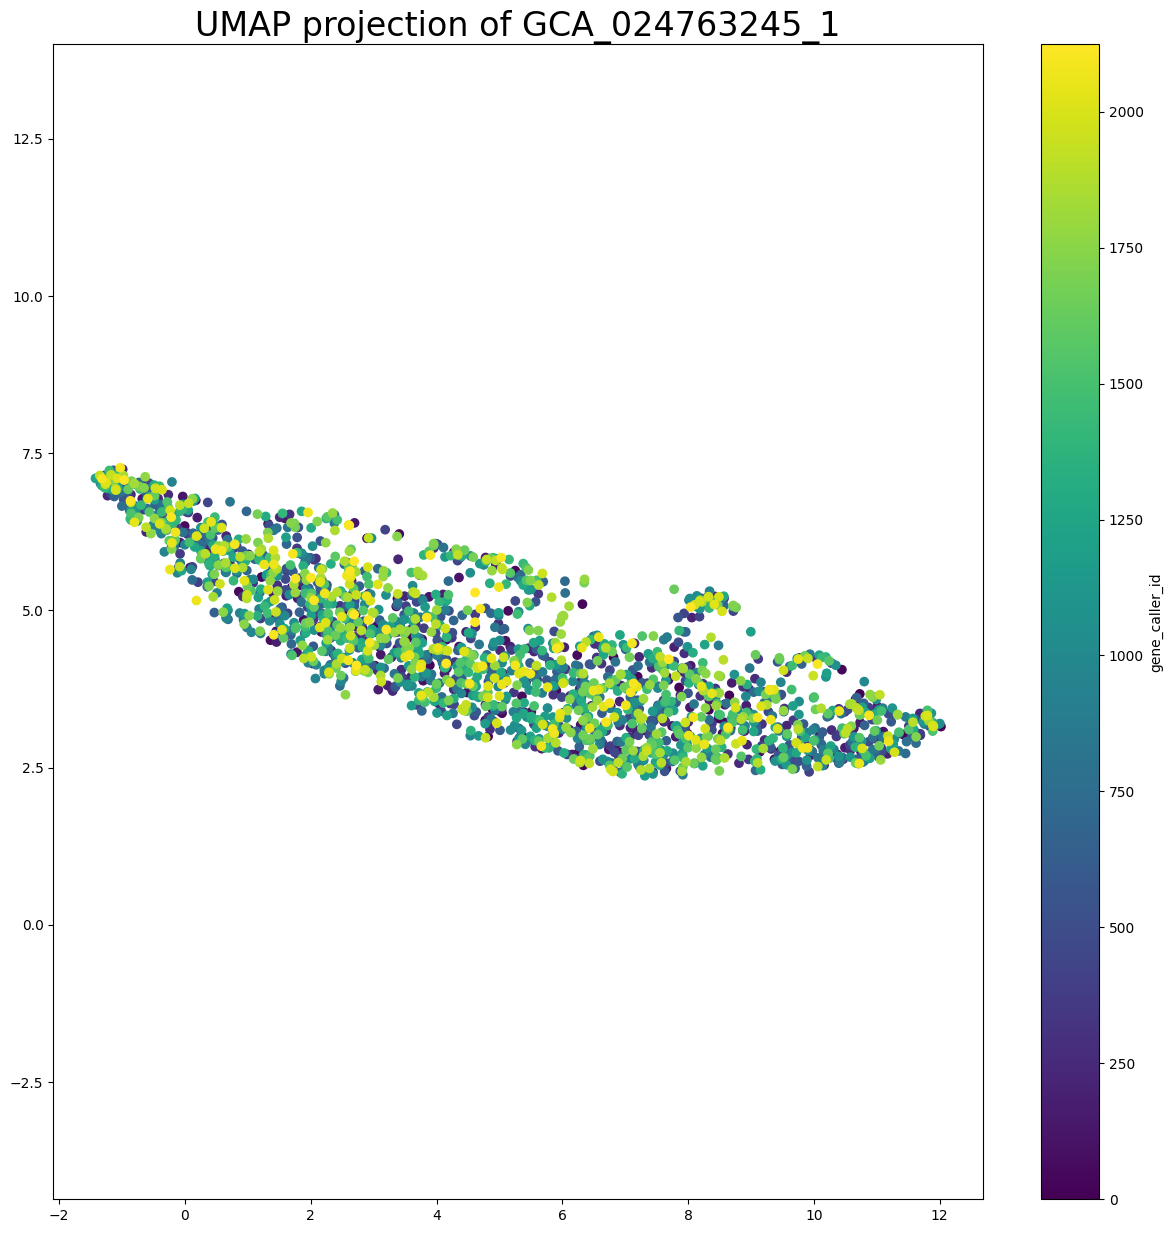

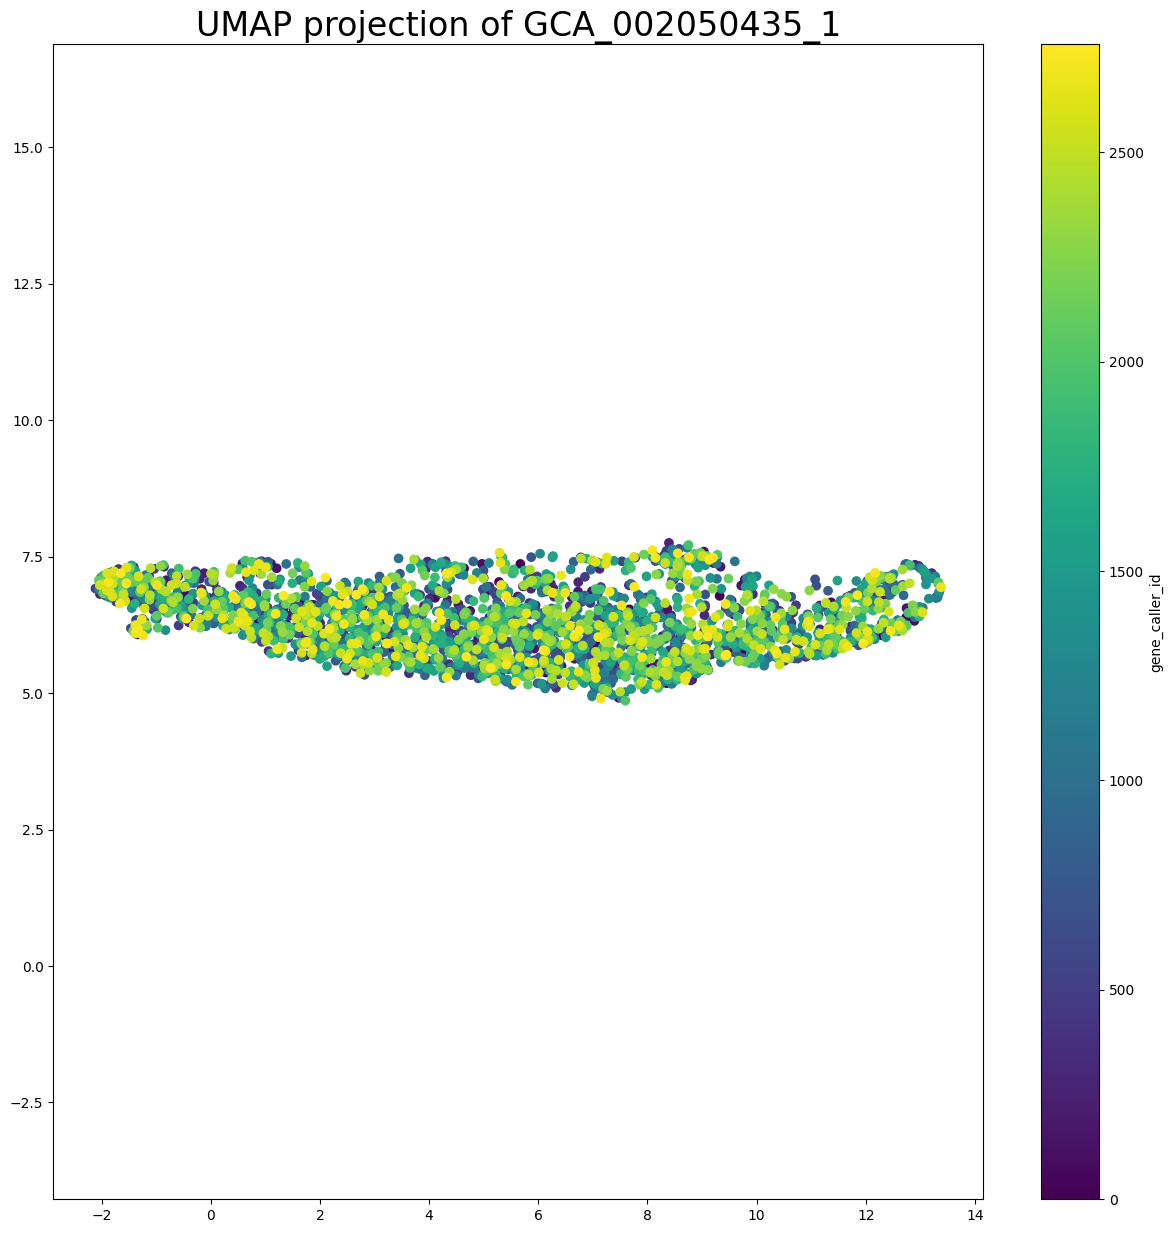

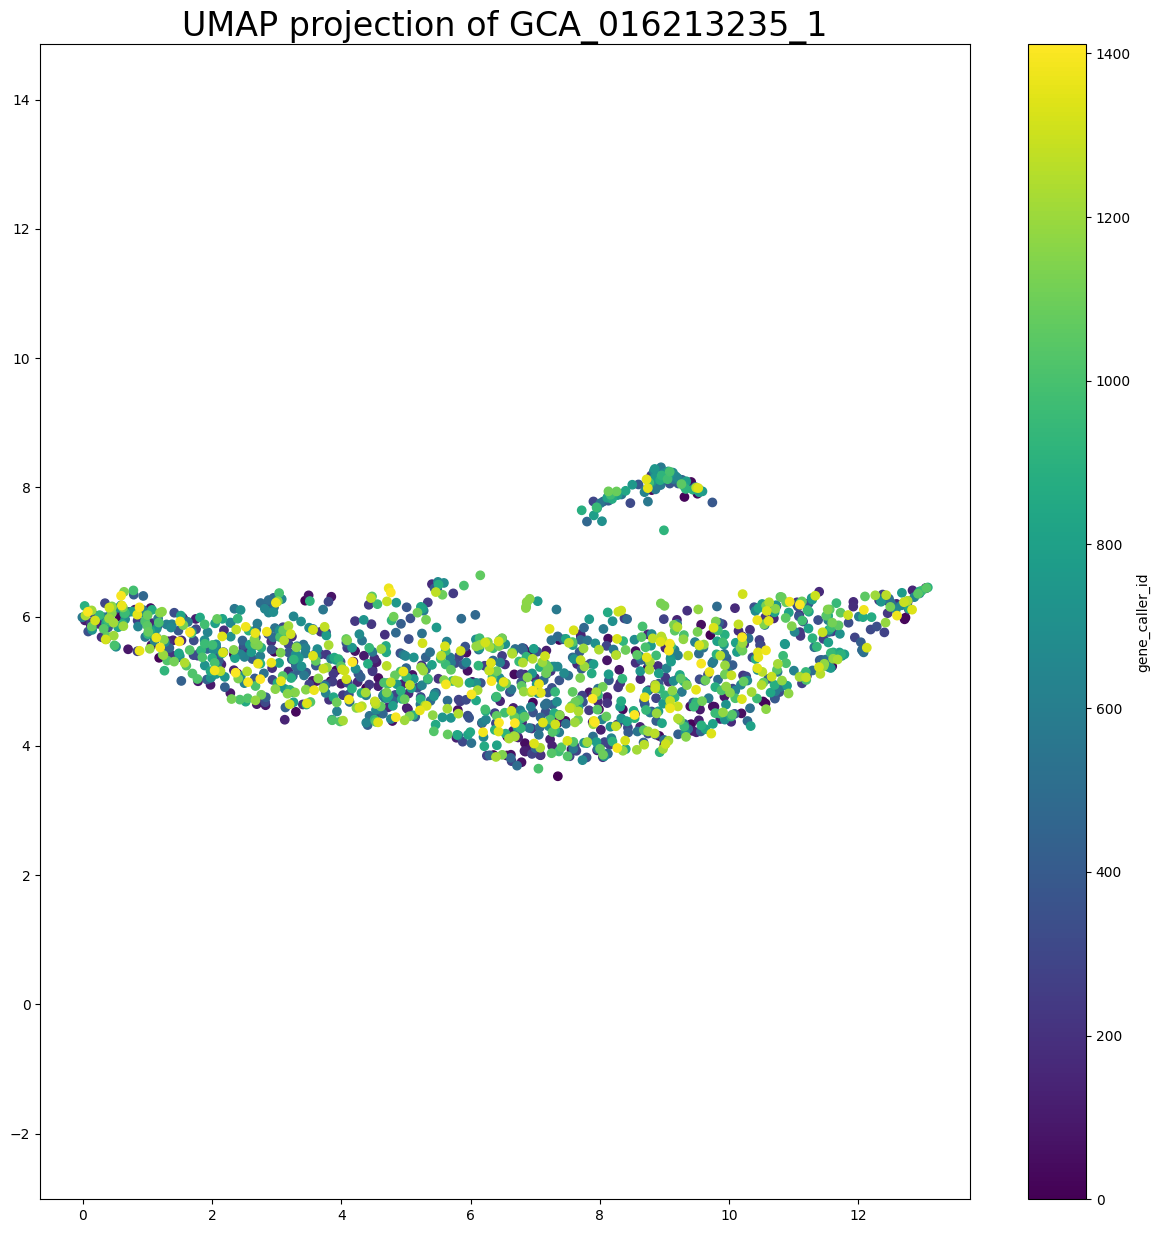

In [74]:
genome_indices = [min_index, max_index, median_index] + rnd_genomes_idx[:10]

for genome in genome_indices:
    vis_genome = abs_df.loc[genome]
    colors = vis_genome['gene_caller_id']
    
    scaled_counts = np.log1p(vis_genome[codon_names])

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled_counts)

    plt.figure(figsize=(15, 15))
    

    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of {0}'.format(vis_genome.index[0]), fontsize=24)
    plt.colorbar(label='gene_caller_id')
    plt.show()

TO DO: think why codons are so homogenious (ask Florian);

TO DO: merge gene clusters functions to the data